In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import multiprocessing

from time import time
import warnings
import os
import sys
import gc
import itertools
from collections import Counter
from datetime import datetime, timedelta
from pathlib import Path
from featexp import get_univariate_plots
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# utils
sys.path.insert(0, '/tf/notebooks/other/kaggle')
from utils import utils_featexp
from utils import utils_features_engineering
from utils import utils_features_plots
from utils import utils_reduce_memory
from utils import utils_statistic

# visualization 
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

# data preprocessing 
import missingno
from featexp import get_univariate_plots
from featexp import get_trend_stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle
from sklearn.decomposition import PCA, TruncatedSVD

# model
import xgboost as xgb
import lightgbm as lgb
import catboost as cb 
# ERROR: AttributeError: type object '_catboost._FloatArrayWrapper' has no attribute '__reduce_cython__'
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# eveluation 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# hyperparameters tuning 
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
seed = 9527

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Data 

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target `isFraud`.

The data is broken into two files identity and transaction, which are joined by `TransactionID`. Not all transactions have corresponding identity information.

The data comes from **Vesta's real-world e-commerce** transactions and contains a wide range of features from device type to product features.

### Categorical Features - Transaction
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual * meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features - Identity
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

**Categorical Features:**
* DeviceType
* DeviceInfo
* id12 - id38

# Idea & trick

把 outlier 用 count 來處理，就能夠讓 tree-base 的演算法來計算 frequencey

In [3]:
main_path = Path('../input/ieee-cis-fraud-detection/')

train_transaction_data = pd.read_csv(main_path / 'train_transaction.csv')
train_identity_data = pd.read_csv(main_path / 'train_identity.csv')
test_transaction_data = pd.read_csv(main_path / 'test_transaction.csv')
test_identity_data = pd.read_csv(main_path / 'test_identity.csv')

print('Number of train transaction data:{}\nNumber of train identity data:{}'.format(
    train_transaction_data.shape[0],
    train_identity_data.shape[0]
))

print('Number of test transaction data:{}\nNumber of test identity data:{}'.format(
    test_transaction_data.shape[0],
    test_identity_data.shape[0]
))

Number of train transaction data:590540
Number of train identity data:144233
Number of test transaction data:506691
Number of test identity data:141907


In [15]:
'''
# Add the path to the feature stats generation code.
import sys
sys.path.insert(0, '/tf/notebooks/facets/facets_overview/python')
# Create the feature stats for the datasets and stringify it.
import base64
from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': train_transaction_data},
                                  {'name': 'test', 'table': test_transaction_data}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
'''

In [7]:
train_transaction_data = utils_reduce_memory.reduce_mem_usage(train_transaction_data)
test_transaction_data = utils_reduce_memory.reduce_mem_usage(test_transaction_data)

Mem. usage decreased to 542.35 Mb (0.0% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)


In [8]:
train_identity_data = utils_reduce_memory.reduce_mem_usage(train_identity_data)
test_identity_data = utils_reduce_memory.reduce_mem_usage(test_identity_data)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


# EDA

1. Distribution of each features
2. Distribution of target by features
3. How many columns contain Null value?
4. Does data has outliers? 

### Target Distribution

Text(0.0, 569880.0, '96.50%')

Text(1.0, 20666.0, '3.50%')

Text(0.5, 0, 'isFraud')

Text(0, 0.5, 'Count')

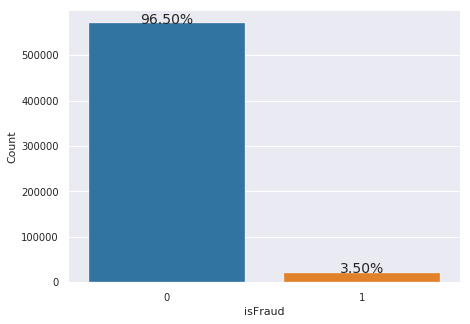

In [20]:
target_count = train_transaction_data['isFraud'].value_counts()
target_per = train_transaction_data['isFraud'].value_counts(normalize=True)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
sns.barplot(target_count.index, target_count.values, ax=ax)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, 
           height + 3,
           '{:1.2f}%'.format(target_per[i] * 100),
           ha="center", fontsize=14) 
ax.set_xlabel('isFraud')
ax.set_ylabel('Count')


## Transcation table

In [4]:
target_col = 'isFraud'
id_col = 'TransactionID'
base_cols = ['TransactionDT', 'TransactionAmt', 'ProductCD']
card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
C_cols = [ 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
D_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']
M_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
V_cols = ['V{}'.format(i) for i in range(1, 340)]
other_cols = ['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']

In [4]:
print('Unique train transcation id:{}'.format(train_transaction_data.TransactionID.nunique()))
print('Unique test transcation id:{}'.format(test_transaction_data.TransactionID.nunique()))

Unique train transcation id:590540
Unique test transcation id:506691


### base columns

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction

* ***time feature***

According the official description `TranscationDT` feature is a timedelta from a give reference datetime (not an actual timestamp). And, some kernal assume that date begin at first of December 2017 at the discussion form, but actully start day is not important.


In [15]:
time_span = test_transaction_data['TransactionDT'].max() - train_transaction_data['TransactionDT'].min()
print('Time span between train and test: {} year'.format(time_span / (365*24*60*60)))

Time span between train and test: 1.0821900367833588 year


Text(0.5, 1.0, 'Distribution of transactiond dates')

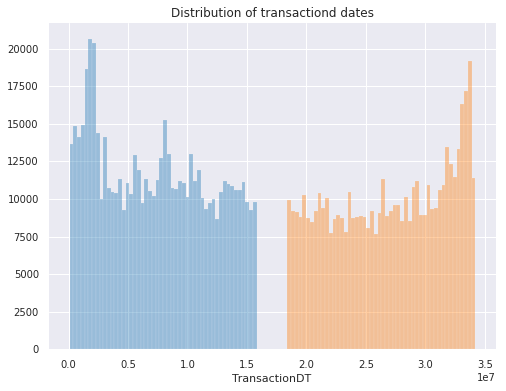

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.distplot(train_transaction_data['TransactionDT'], label='train', kde=False, ax=ax)
sns.distplot(test_transaction_data['TransactionDT'], label='test', kde=False, ax=ax)
ax.set_title('Distribution of transactiond dates')

In [34]:
startdate = datetime.strptime('2017-12-01', '%Y-%m-%d')
train_transaction_data['TransactionDT'] = train_transaction_data['TransactionDT'].apply(lambda x: (startdate + timedelta(seconds = x)))
test_transaction_data['TransactionDT'] = test_transaction_data['TransactionDT'].apply(lambda x: (startdate + timedelta(seconds = x)))


In [52]:
train_transaction_data['tran_date'] = train_transaction_data['TransactionDT'].apply(lambda x:x.strftime('%Y-%m-%d'))
test_transaction_data['tran_date'] = test_transaction_data['TransactionDT'].apply(lambda x:x.strftime('%Y-%m-%d'))


**Conclusion**

Train data and test data have different datetime with data point, so it could use time split method to do cross validation.

                                       Plots for TransactionDT                                        


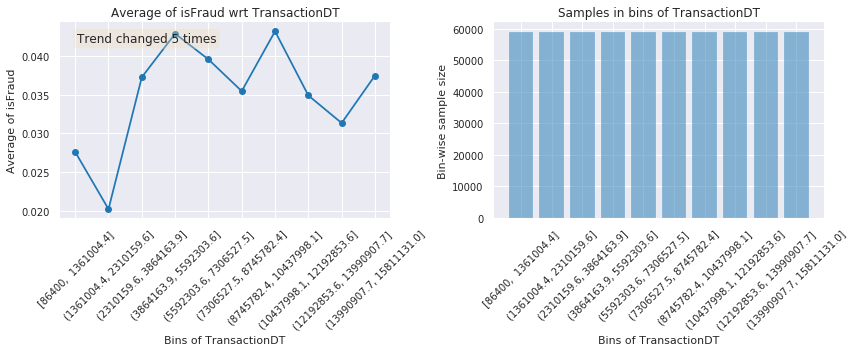

--------------------------------------------------------------------------------------------------------------


                                       Plots for TransactionAmt                                       


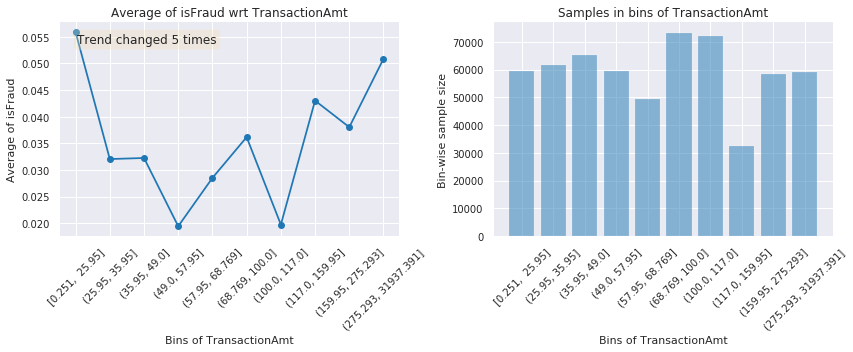

--------------------------------------------------------------------------------------------------------------




In [10]:
get_univariate_plots(data=train_transaction_data[['TransactionDT', 'TransactionAmt', target_col]], 
                     target_col=target_col, 
                     bins=10,
                     features_list=['TransactionDT', 'TransactionAmt'])

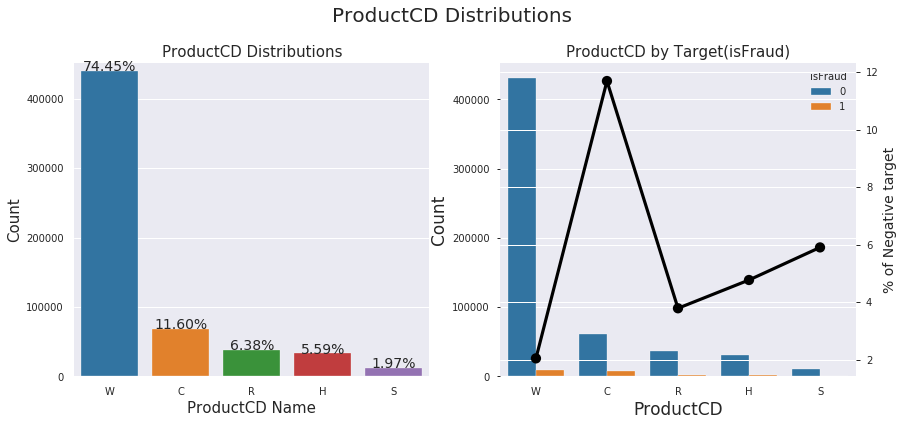

In [12]:
utils_features_plots.plot_cate_feature_distribtion(train_transaction_data, 'ProductCD', target_col)

* ***Card columns***

In [8]:
train_transaction_data[card_cols].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

In [9]:
utils_statistic.resumetable(train_transaction_data[card_cols])

Dataset Shape: (590540, 6)


Name   dtypes  Missing  Missing%  Uniques First Value Second Value  \
0  card1    int64        0    0.0000    13553       13926         2755   
1  card2  float64     8933    1.5127      500         NaN          404   
2  card3  float64     1565    0.2650      114         150          150   
3  card4   object     1577    0.2670        4    discover   mastercard   
4  card5  float64     4259    0.7212      119         142          102   
5  card6   object     1571    0.2660        4      credit       credit   

  Third Value  Entropy  
0        4663     9.97  
1         490     6.32  
2         150     0.68  
3        visa     1.09  
4         166     2.66  
5       debit     0.82

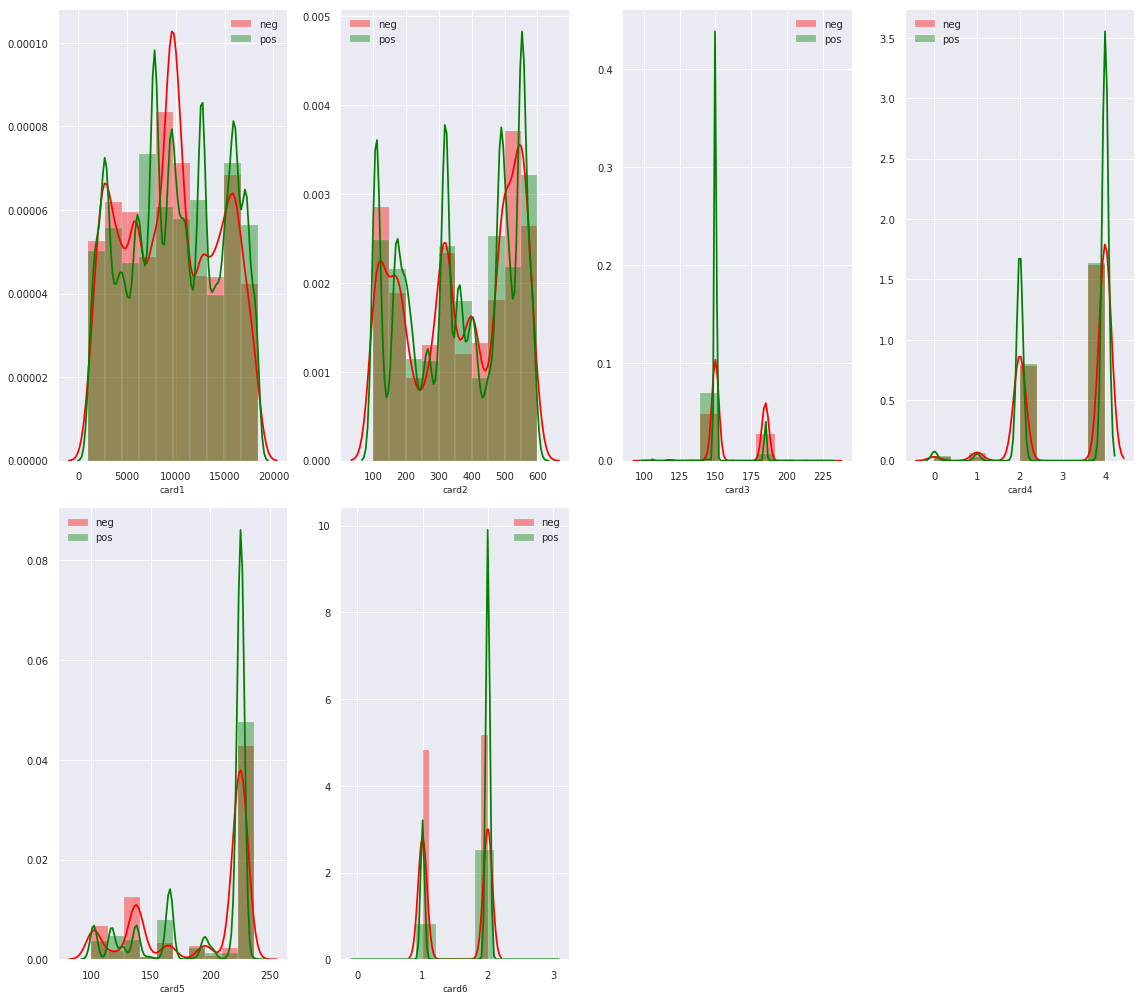

In [35]:
neg = train_transaction_data.isFraud == 1
pos = train_transaction_data.isFraud == 0
utils_features_plots.plot_feature_distribution_w_target(
    data=train_transaction_data, 
    neg=neg, 
    pos=pos, 
    features=card_cols, 
    label1='neg', 
    label2='pos')

                                           Plots for card1                                            


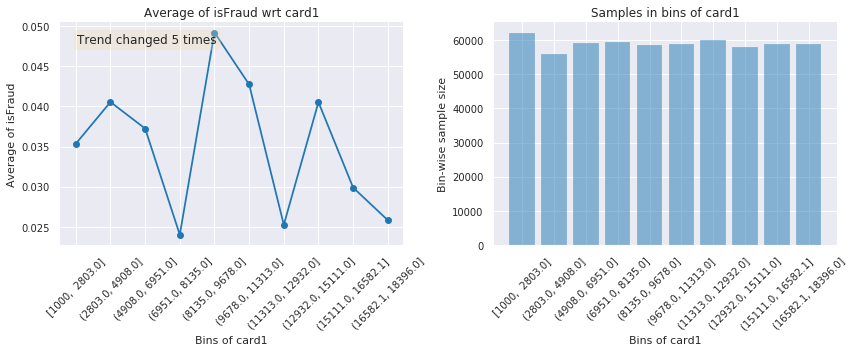

--------------------------------------------------------------------------------------------------------------


                                           Plots for card2                                            


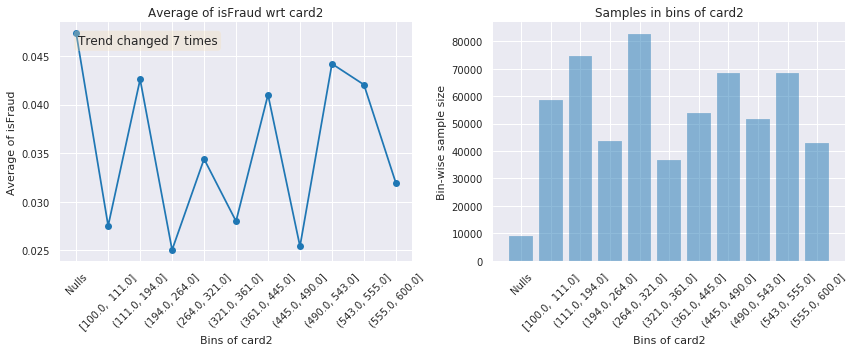

--------------------------------------------------------------------------------------------------------------


                                           Plots for card3                                            


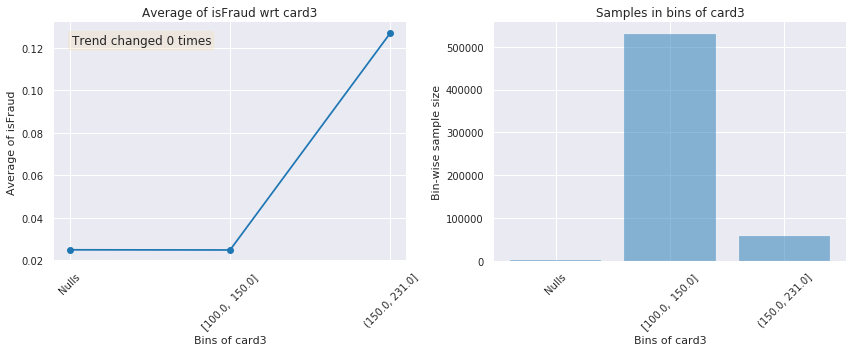

--------------------------------------------------------------------------------------------------------------


card4 is categorical. Categorical features not supported yet.
                                           Plots for card5                                            


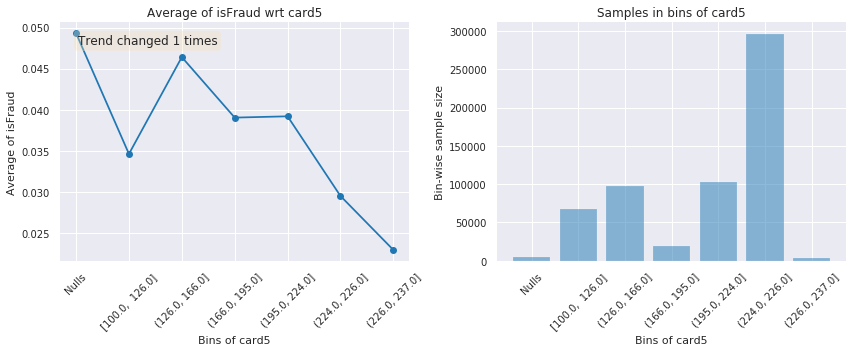

--------------------------------------------------------------------------------------------------------------


card6 is categorical. Categorical features not supported yet.


In [43]:
get_univariate_plots(data=train_transaction_data[card_cols + [target_col]], 
                     target_col=target_col, 
                     bins=10,
                     features_list=card_cols)

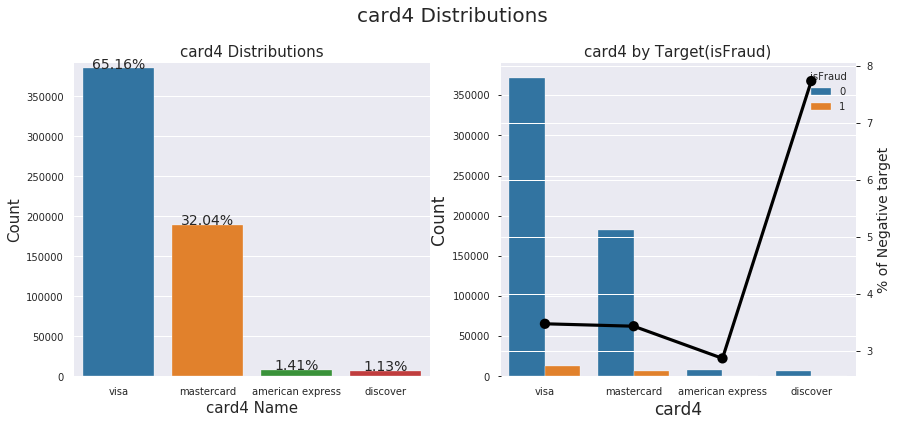

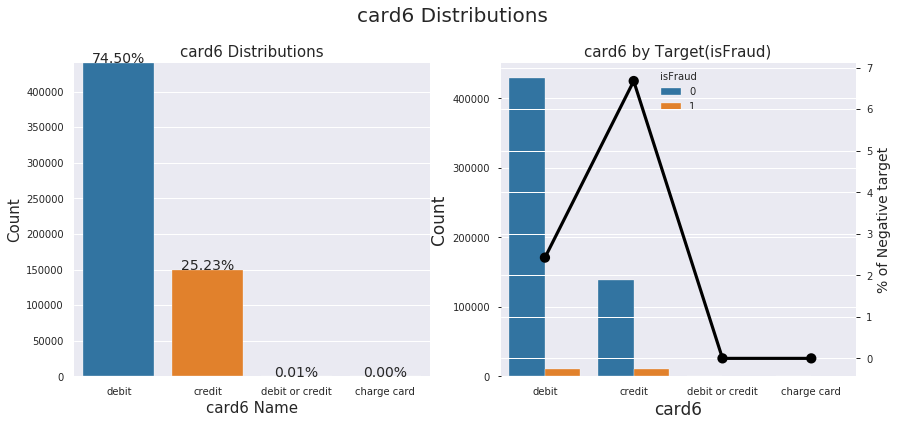

In [46]:
for c in ['card4', 'card6']:
    utils_features_plots.plot_cate_feature_distribtion(train_transaction_data, c, target_col)

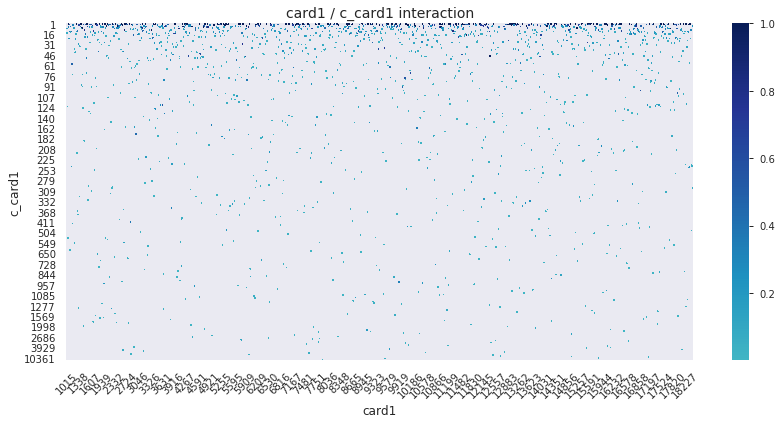

-----------------------------------------------------------------------------------------------------




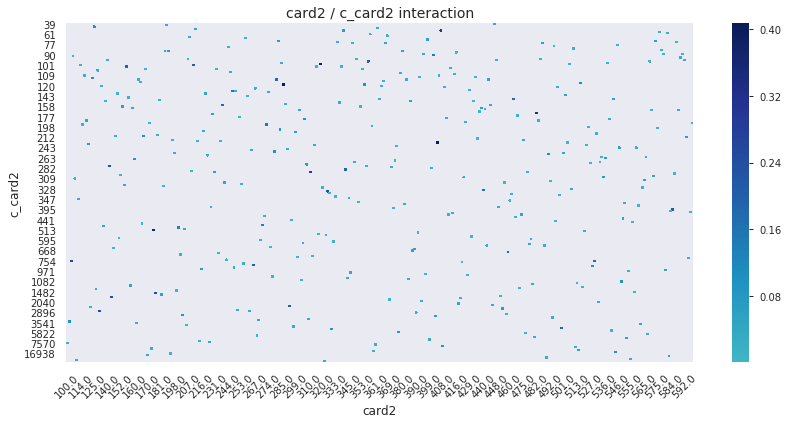

-----------------------------------------------------------------------------------------------------




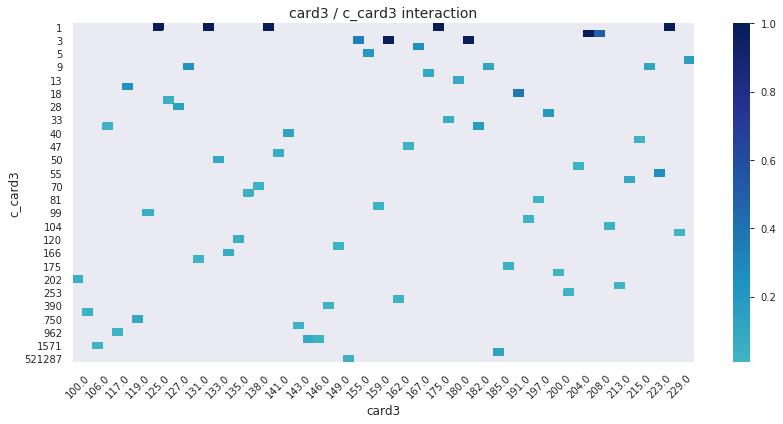

-----------------------------------------------------------------------------------------------------




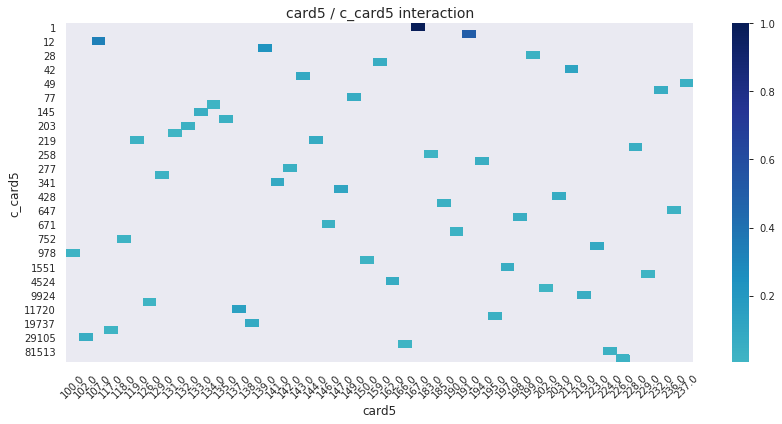

-----------------------------------------------------------------------------------------------------




In [8]:
continue_card_cols = [i for i in card_cols if str(train_transaction_data[i].dtype) not in ['object', 'category']]
utils_features_plots.plot_feature_freq(train_transaction_data, continue_card_cols, target_col)


In [27]:
cs_res_df = pd.DataFrame(columns=['col_name', 'auc'])
for idx, c in enumerate(card_cols):
    cs_res_df.loc[idx, 'col_name'] = c
    cs_res_df.loc[idx, 'auc'] = covariate_shift(train_data=train_transaction_data, 
                                                test_data=test_transaction_data, 
                                                feature=c, 
                                                seed=42)
cs_res_df    

col_name       auc
0    card1  0.540119
1    card2   0.54239
2    card3  0.512437
3    card4  0.509674
4    card5  0.531442
5    card6  0.510208

* ***D columns***

In [23]:
train_transaction_data[D_cols].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14  \
0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN   
1    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN   
2    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN   
3  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN   
4    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN   

     D15  
0    0.0  
1    0.0  
2  315.0  
3  111.0  
4    NaN

In [12]:
utils_statistic.resumetable(train_transaction_data[D_cols])

Dataset Shape: (590540, 15)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0    D1  float64     1269    0.2149      641         14.0           0.0   
1    D2  float64   280797   47.5492      641          NaN           NaN   
2    D3  float64   262878   44.5149      649         13.0           NaN   
3    D4  float64   168922   28.6047      808          NaN           0.0   
4    D5  float64   309841   52.4674      688          NaN           NaN   
5    D6  float64   517353   87.6068      829          NaN           NaN   
6    D7  float64   551623   93.4099      597          NaN           NaN   
7    D8  float64   515614   87.3123    12353          NaN           NaN   
8    D9  float64   515614   87.3123       24          NaN           NaN   
9   D10  float64    76022   12.8733      818         13.0           0.0   
10  D11  float64   279287   47.2935      676         13.0           NaN   
11  D12  float64   525823   89.0410      635          NaN           NaN   
12  D13  float64   528588   89.5093      577          NaN           NaN   
13  D14  float64   528353   89.4695      802          NaN           NaN   
14  D15  float64    89113   15.0901      859          0.0           0.0   

    Third Value  Entropy  
0           0.0     5.57  
1           NaN     8.57  
2           NaN     5.60  
3           0.0     6.42  
4           NaN     5.95  
5           NaN     4.09  
6           NaN     4.29  
7           NaN    11.32  
8           NaN     4.29  
9           0.0     6.09  
10        315.0     6.73  
11          NaN     3.70  
12          NaN     2.26  
13          NaN     3.14  
14        315.0     6.88

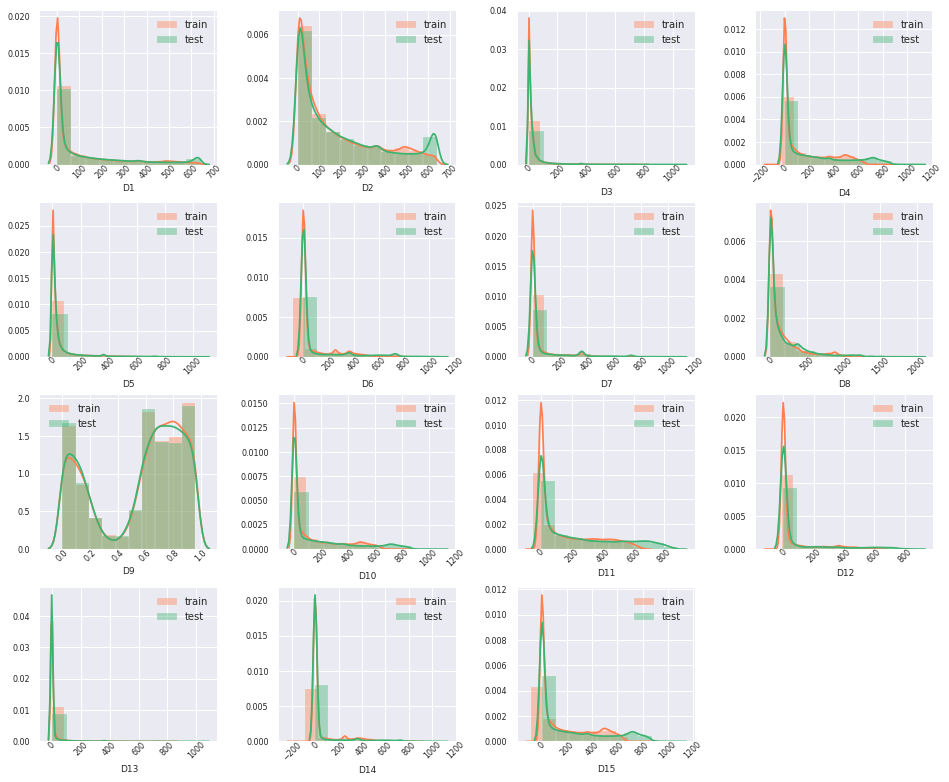

In [10]:
utils_features_plots.plot_feature_distribution(
    df1=train_transaction_data, 
    df2=test_transaction_data, 
    label1='train', 
    label2='test', 
    features=D_cols
)    

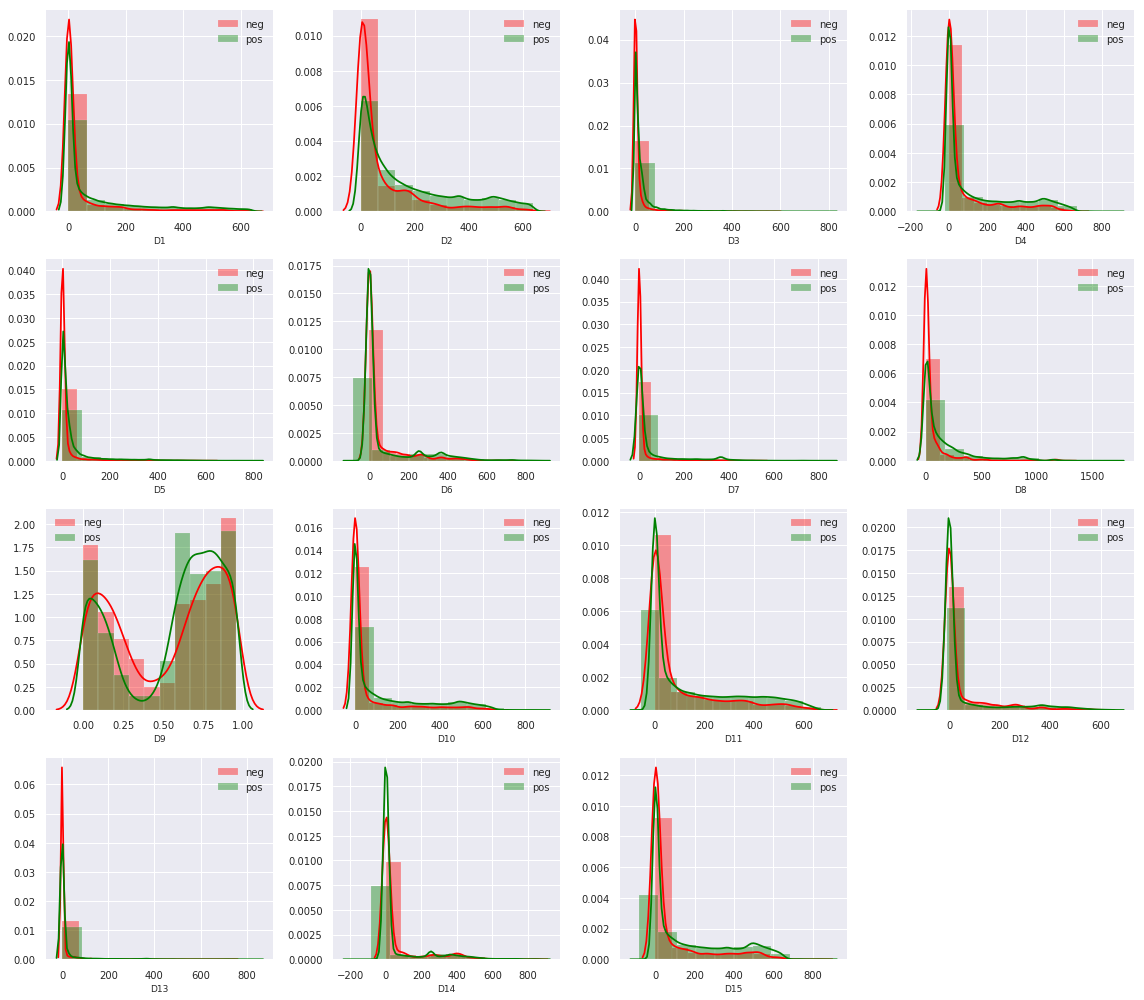

In [9]:
neg = train_transaction_data.isFraud == 1
pos = train_transaction_data.isFraud == 0
utils_features_plots.plot_feature_distribution_w_target(
    data=train_transaction_data, 
    neg=neg, 
    pos=pos, 
    features=D_cols, 
    label1='neg', 
    label2='pos')

                                             Plots for D1                                             


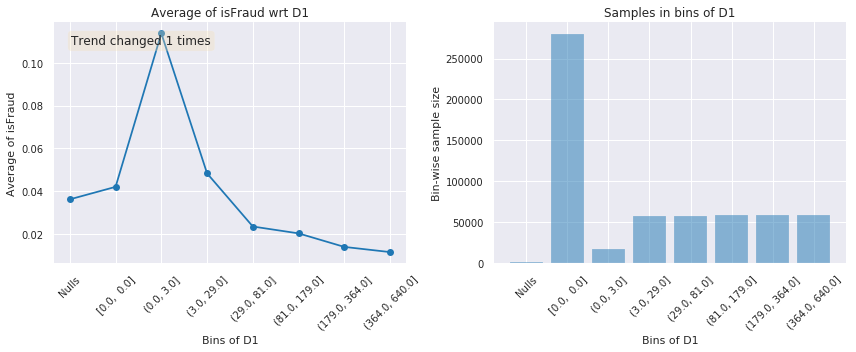

--------------------------------------------------------------------------------------------------------------


                                             Plots for D2                                             


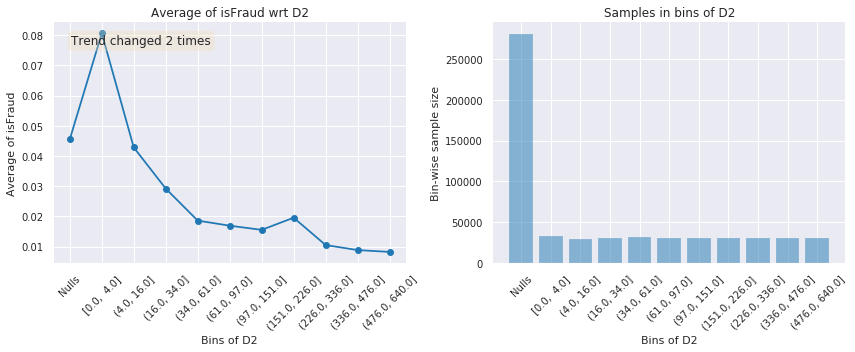

--------------------------------------------------------------------------------------------------------------


                                             Plots for D3                                             


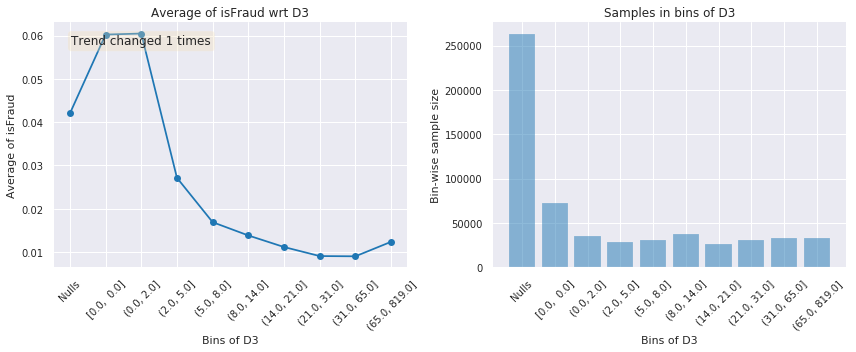

--------------------------------------------------------------------------------------------------------------


                                             Plots for D4                                             


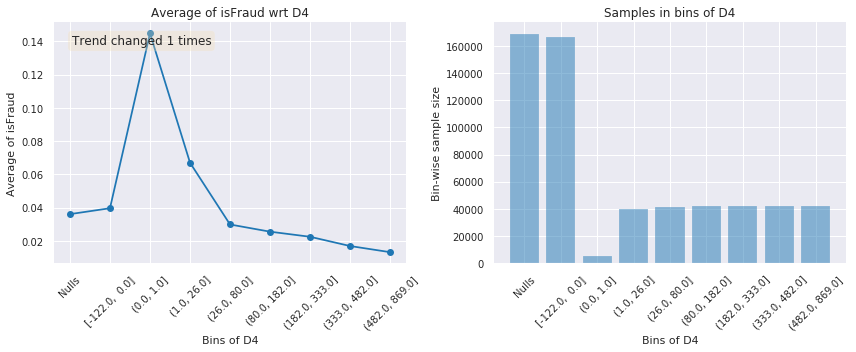

--------------------------------------------------------------------------------------------------------------


                                             Plots for D5                                             


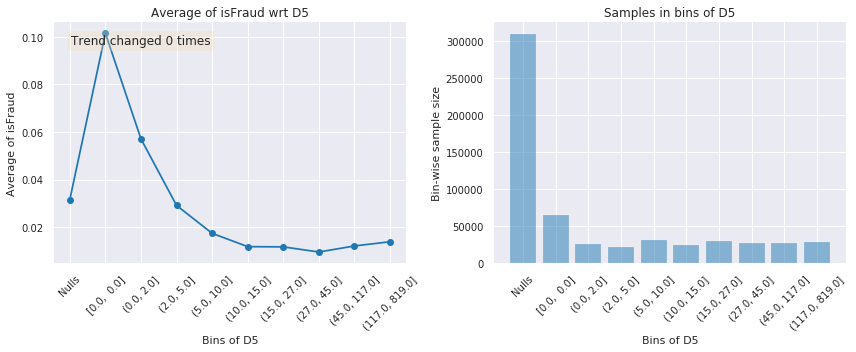

--------------------------------------------------------------------------------------------------------------


                                             Plots for D6                                             


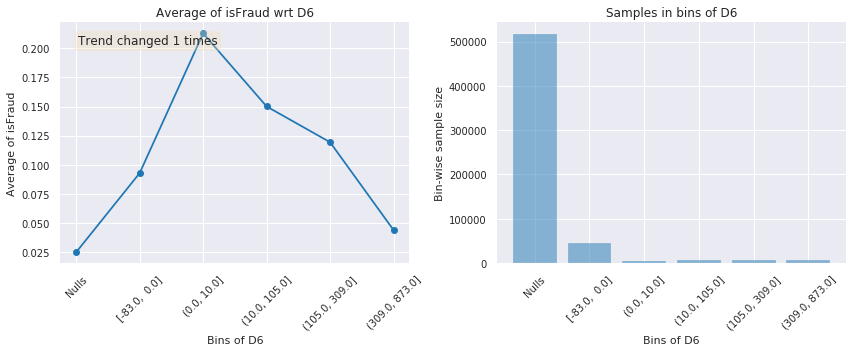

--------------------------------------------------------------------------------------------------------------


                                             Plots for D7                                             


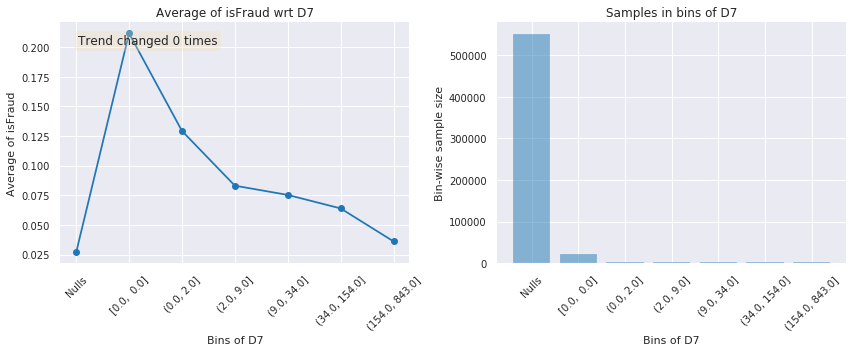

--------------------------------------------------------------------------------------------------------------


                                             Plots for D8                                             


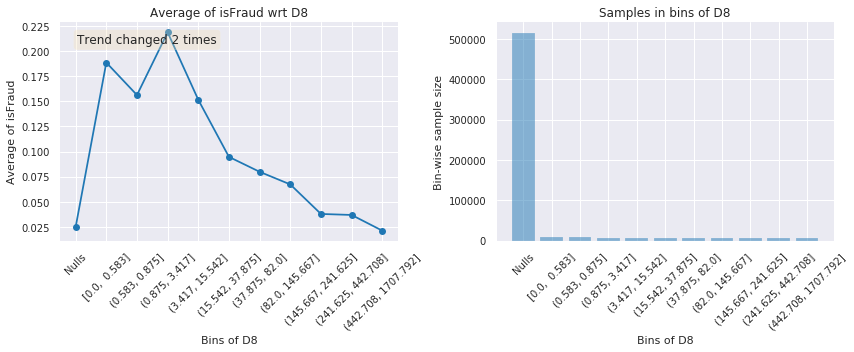

--------------------------------------------------------------------------------------------------------------


                                             Plots for D9                                             


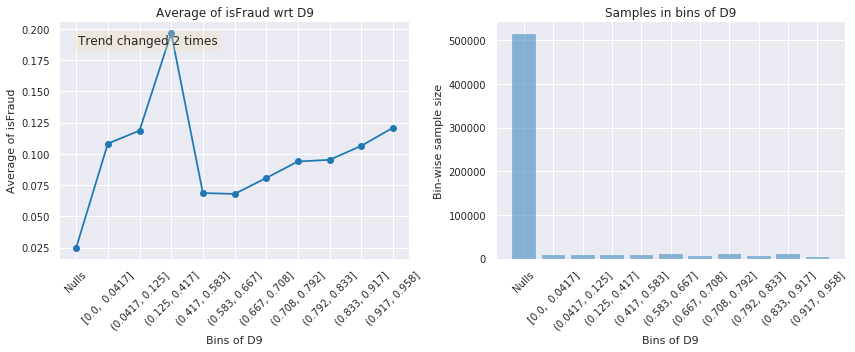

--------------------------------------------------------------------------------------------------------------


                                            Plots for D10                                             


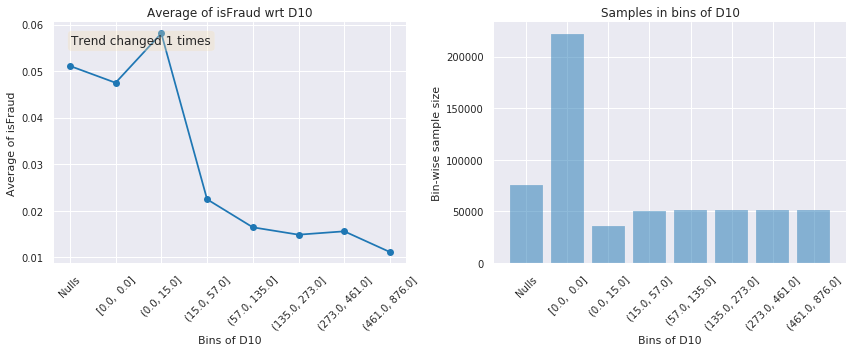

--------------------------------------------------------------------------------------------------------------


                                            Plots for D11                                             


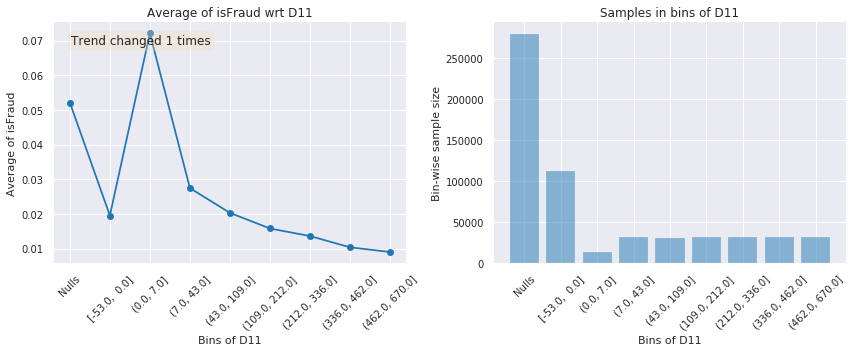

--------------------------------------------------------------------------------------------------------------


                                            Plots for D12                                             


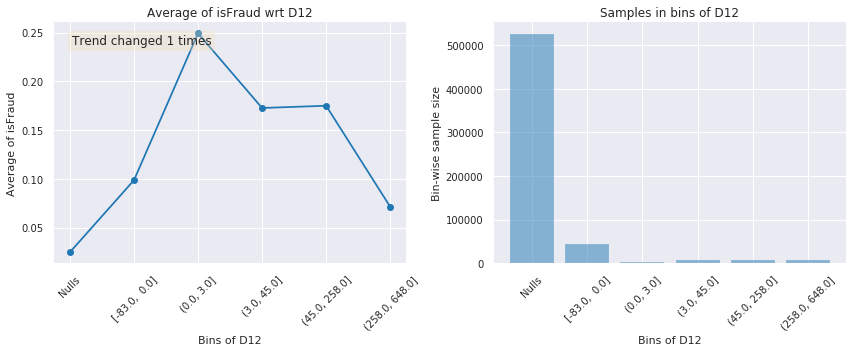

--------------------------------------------------------------------------------------------------------------


                                            Plots for D13                                             


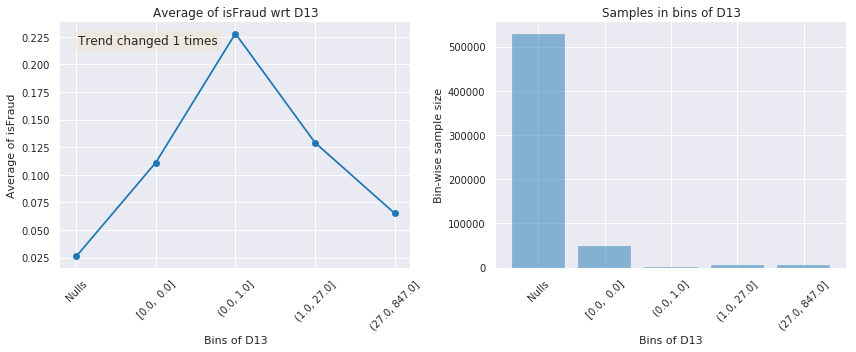

--------------------------------------------------------------------------------------------------------------


                                            Plots for D14                                             


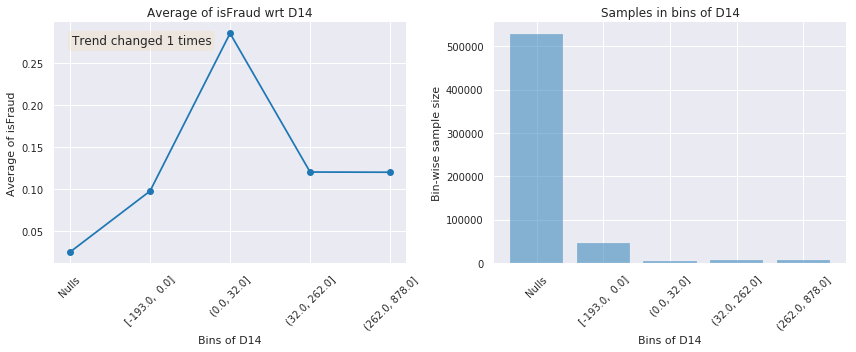

--------------------------------------------------------------------------------------------------------------


                                            Plots for D15                                             


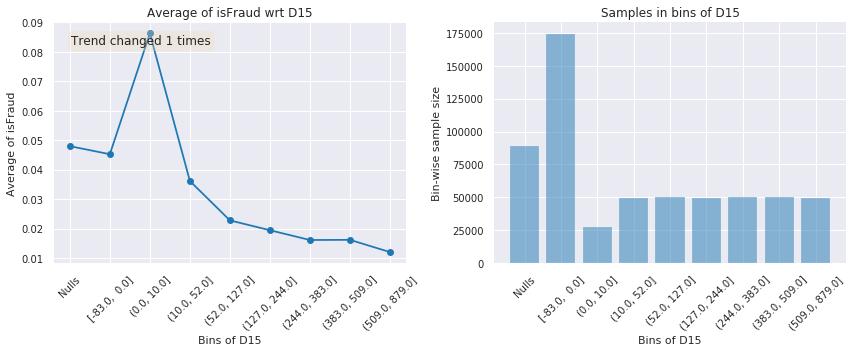

--------------------------------------------------------------------------------------------------------------




In [17]:
get_univariate_plots(data=train_transaction_data[D_cols + [target_col]], 
                     target_col=target_col, 
                     bins=10,
                     features_list=D_cols)

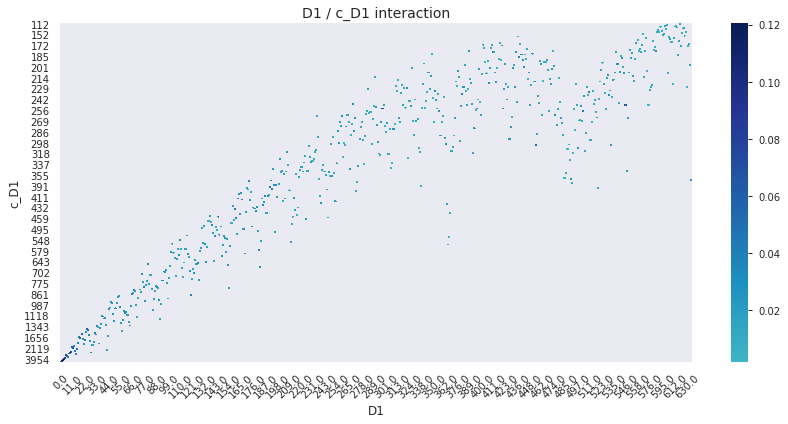

-----------------------------------------------------------------------------------------------------




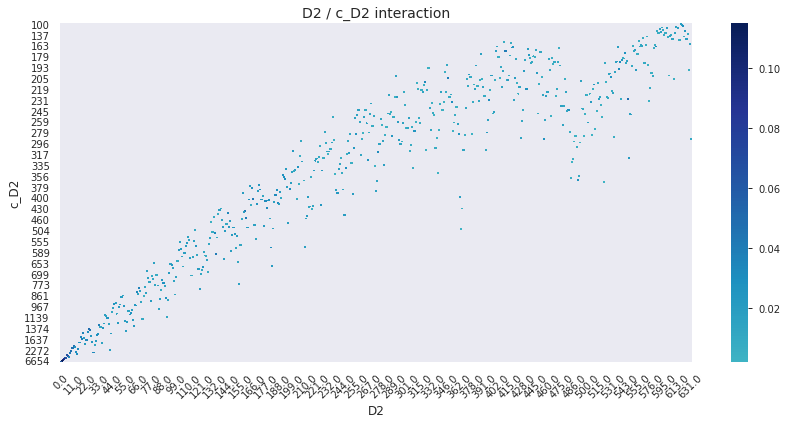

-----------------------------------------------------------------------------------------------------




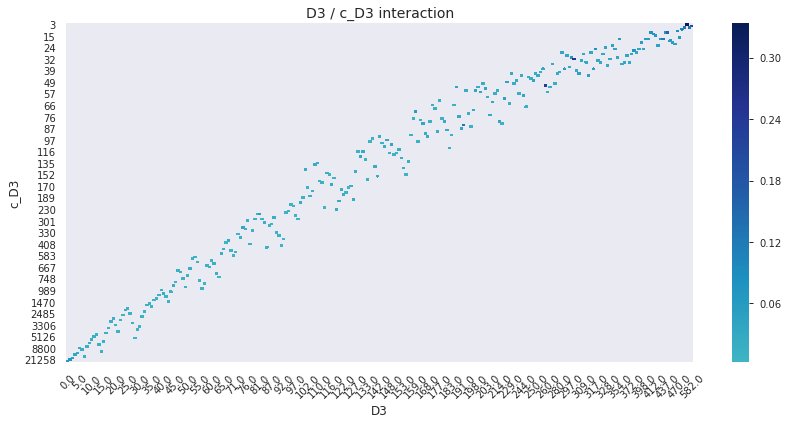

-----------------------------------------------------------------------------------------------------




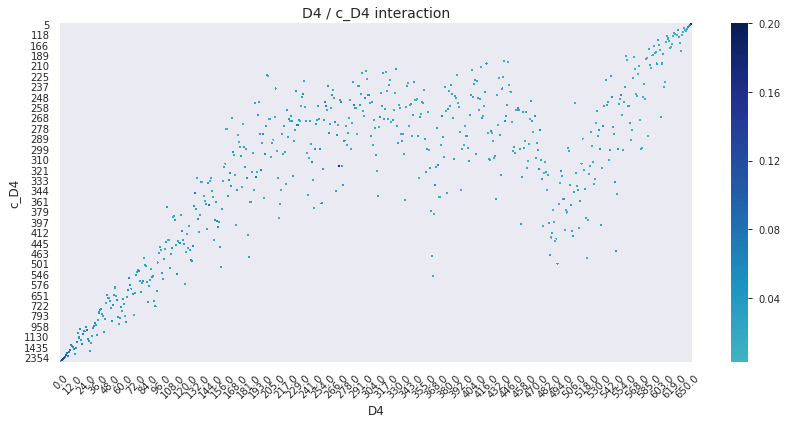

-----------------------------------------------------------------------------------------------------




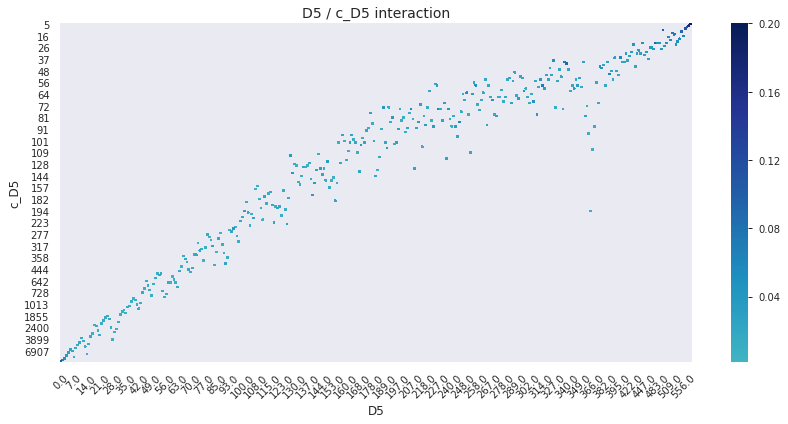

-----------------------------------------------------------------------------------------------------




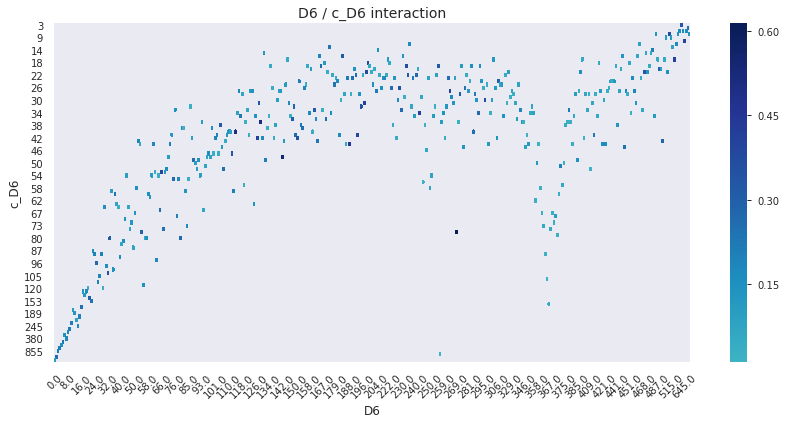

-----------------------------------------------------------------------------------------------------




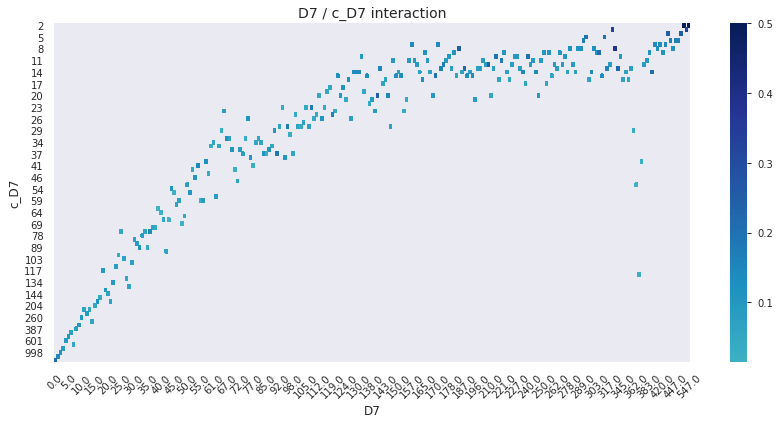

-----------------------------------------------------------------------------------------------------




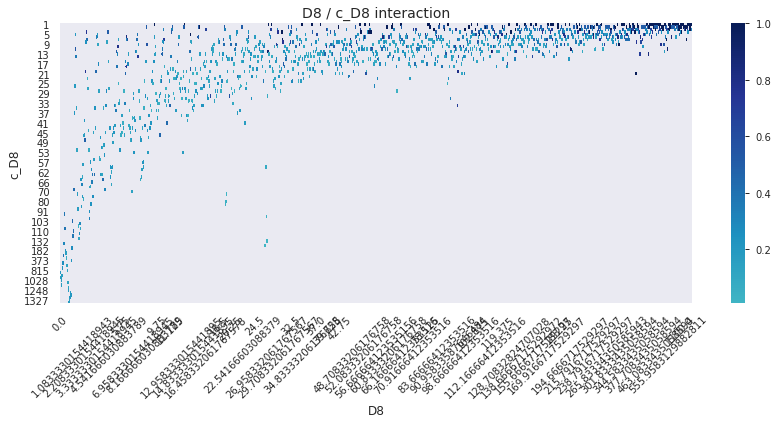

-----------------------------------------------------------------------------------------------------




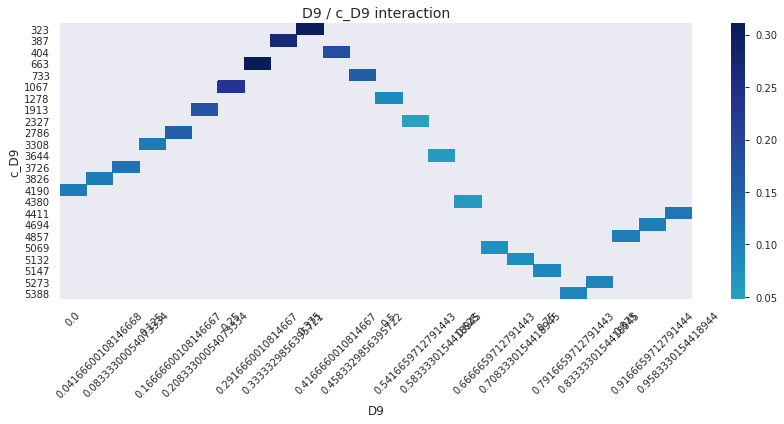

-----------------------------------------------------------------------------------------------------




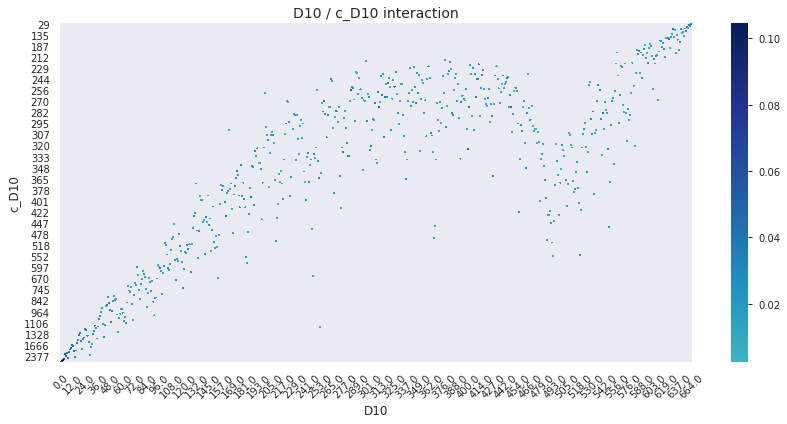

-----------------------------------------------------------------------------------------------------




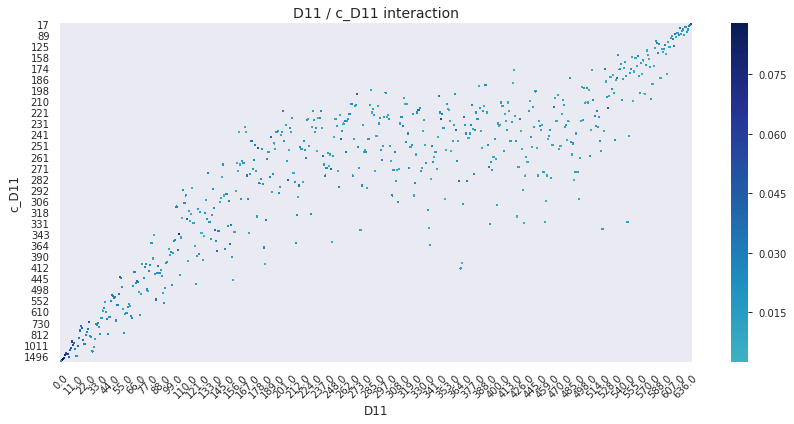

-----------------------------------------------------------------------------------------------------




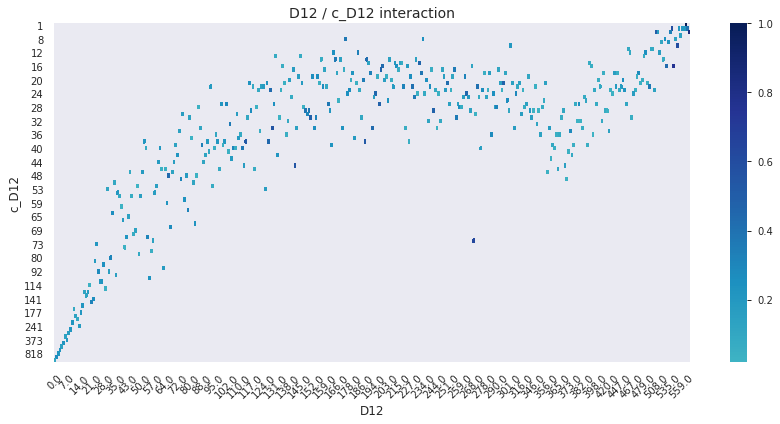

-----------------------------------------------------------------------------------------------------




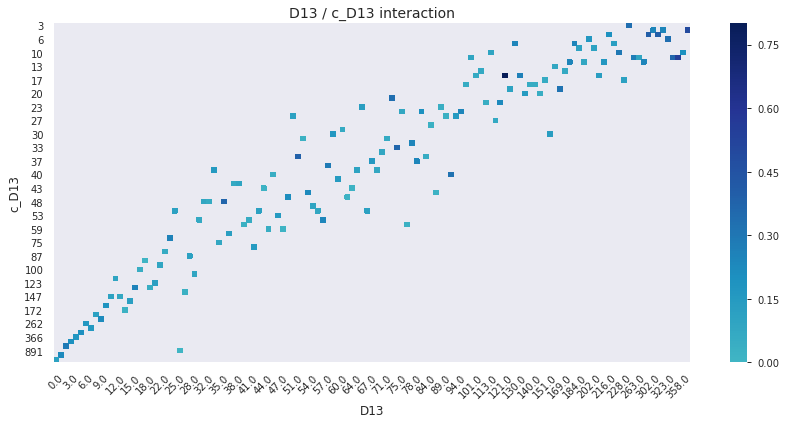

-----------------------------------------------------------------------------------------------------




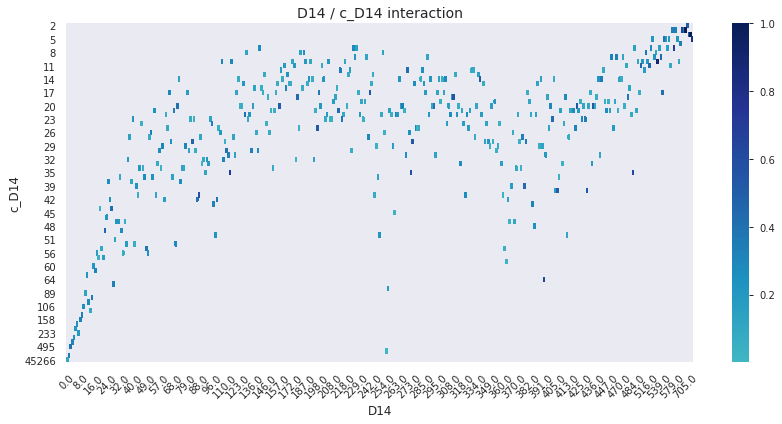

-----------------------------------------------------------------------------------------------------




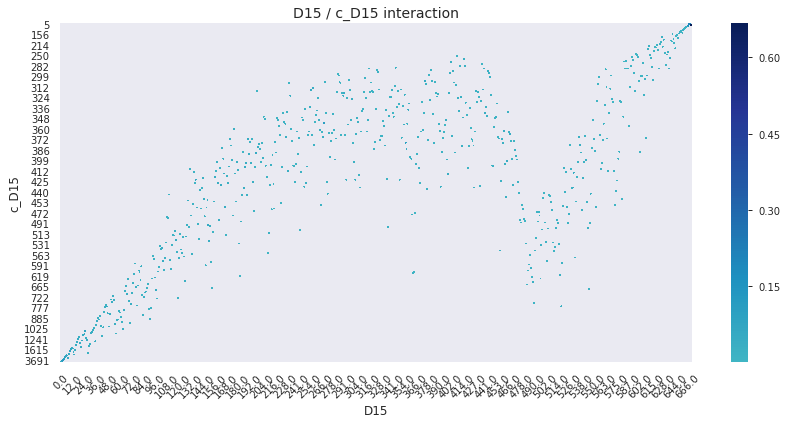

-----------------------------------------------------------------------------------------------------




In [10]:
continue_D_cols = [i for i in D_cols if str(train_transaction_data[i].dtype) not in ['object', 'category']]
utils_features_plots.plot_feature_freq(train_transaction_data, continue_D_cols, target_col)


In [19]:
cs_res_df = pd.DataFrame(columns=['col_name', 'auc'])
for idx, c in enumerate(D_cols):
    cs_res_df.loc[idx, 'col_name'] = c
    cs_res_df.loc[idx, 'auc'] = covariate_shift(train_data=train_transaction_data, 
                                                                test_data=test_transaction_data, 
                                                                feature=c, 
                                                                seed=42)
    

In [20]:
cs_res_df

col_name       auc
0        D1  0.538685
1        D2  0.531657
2        D3  0.530067
3        D4  0.622661
4        D5  0.549485
5        D6  0.564943
6        D7  0.526588
7        D8  0.515788
8        D9  0.509782
9       D10  0.629663
10      D11  0.593252
11      D12  0.516621
12      D13  0.570702
13      D14  0.563321
14      D15  0.656814

* ***C columns***

In [48]:
utils_statistic.resumetable(train_transaction_data[C_cols])

Dataset Shape: (590540, 14)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0    C1  float64        0       0.0     1657          1.0           1.0   
1    C2  float64        0       0.0     1216          1.0           1.0   
2    C3  float64        0       0.0       27          0.0           0.0   
3    C4  float64        0       0.0     1260          0.0           0.0   
4    C5  float64        0       0.0      319          0.0           0.0   
5    C6  float64        0       0.0     1328          1.0           1.0   
6    C7  float64        0       0.0     1103          0.0           0.0   
7    C8  float64        0       0.0     1253          0.0           0.0   
8    C9  float64        0       0.0      205          1.0           0.0   
9   C10  float64        0       0.0     1231          0.0           0.0   
10  C11  float64        0       0.0     1476          2.0           1.0   
11  C12  float64        0       0.0     1199          0.0           0.0   
12  C13  float64        0       0.0     1597          1.0           1.0   
13  C14  float64        0       0.0     1108          1.0           1.0   

    Third Value  Entropy  
0           1.0     2.72  
1           1.0     2.75  
2           0.0     0.04  
3           0.0     1.12  
4           0.0     2.06  
5           1.0     2.52  
6           0.0     0.71  
7           0.0     1.25  
8           1.0     2.62  
9           0.0     1.23  
10          1.0     2.17  
11          0.0     0.95  
12          1.0     4.66  
13          1.0     2.67

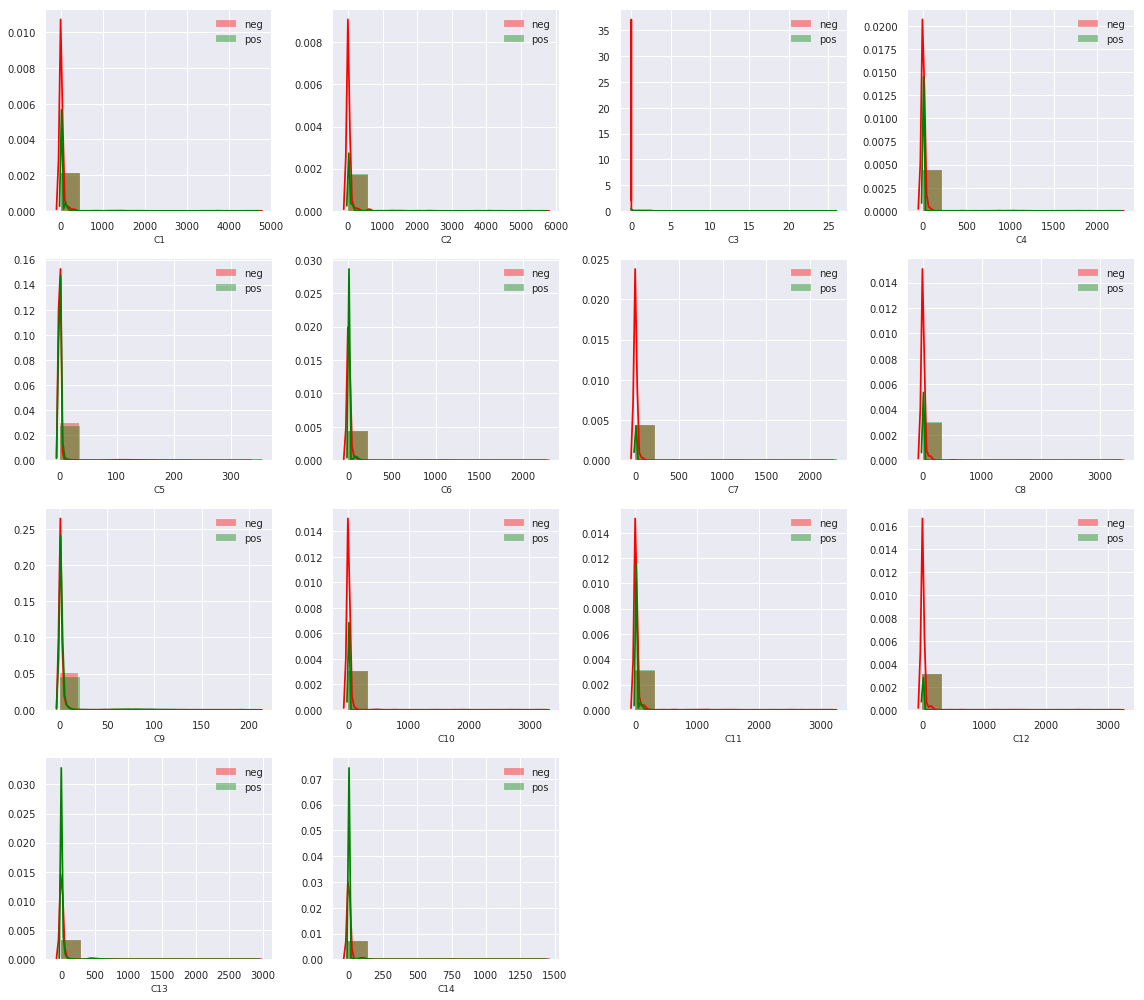

In [49]:
neg = train_transaction_data.isFraud == 1
pos = train_transaction_data.isFraud == 0
utils_features_plots.plot_feature_distribution_w_target(
    data=train_transaction_data, 
    neg=neg, 
    pos=pos, 
    features=C_cols, 
    label1='neg', 
    label2='pos')

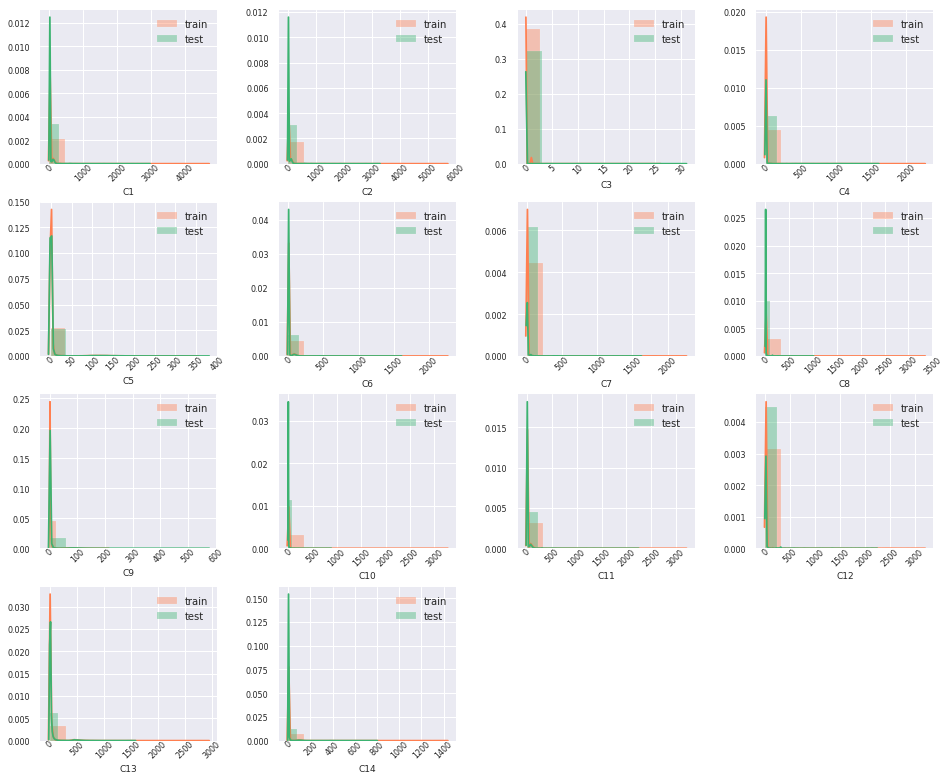

In [7]:
utils_features_plots.plot_feature_distribution(
    df1=train_transaction_data, 
    df2=test_transaction_data, 
    label1='train', 
    label2='test', 
    features=C_cols
)    

In [9]:
train_transaction_data[C_cols].describe()

C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569018     154.668899       0.150536      68.848459   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144574   
std        25.786976      71.508467      61.727304      95.378574   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       0.000000   
max       349.000000    2253.000000    2255.000000    3331.000000   

                  C9            C10            C11            C12  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        4.480240       5.240343      10.241521       4.076227   
std        16.674897      95.581443      94.336292      86.666218   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       0.000000       2.000000       0.000000   
max       210.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14  
count  590540.000000  590540.000000  
mean       32.539918       8.295215  
std       129.364844      49.544262  
min         0.000000       0.000000  
25%         1.000000       1.000000  
50%         3.000000       1.000000  
75%        12.000000       2.000000  
max      2918.000000    1429.000000

In [8]:
test_transaction_data[C_cols].describe()

C1             C2             C3             C4  \
count  506688.000000  506688.000000  506688.000000  506688.000000   
mean       10.093211      10.714635       0.027403       2.385875   
std        79.334782      88.896921       0.227753      41.942977   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       1.000000   
max      2950.000000    3275.000000      31.000000    1601.000000   

                  C5             C6             C7             C8  \
count  506688.000000  506688.000000  506688.000000  506688.000000   
mean        4.962701       6.854992       1.678173       1.893994   
std        25.462195      46.783565      37.874827      26.766115   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       1.000000   
max       376.000000    1601.000000    1621.000000    1005.000000   

                  C9            C10            C11            C12  \
count  506688.000000  506688.000000  506688.000000  506688.000000   
mean        4.611943       1.810149       7.484594       2.649486   
std        21.282640      23.692393      61.322505      53.973060   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       1.000000       2.000000       1.000000   
max       572.000000     881.000000    2234.000000    2234.000000   

                 C13            C14  
count  501943.000000  506688.000000  
mean       27.816035       6.083890  
std       101.114033      28.315616  
min         0.000000       0.000000  
25%         1.000000       1.000000  
50%         3.000000       1.000000  
75%        13.000000       2.000000  
max      1562.000000     797.000000

                                             Plots for C1                                             


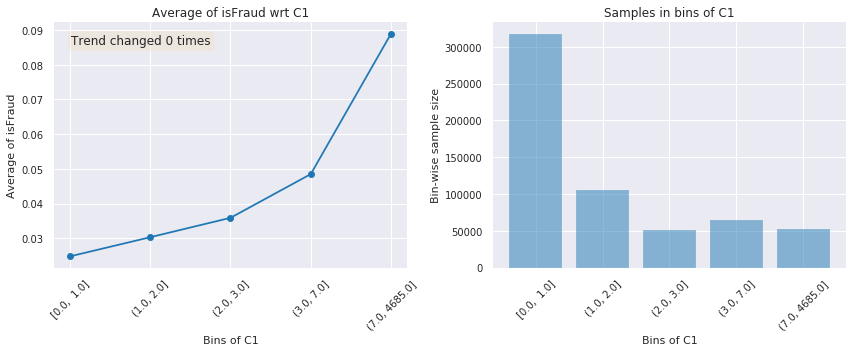

--------------------------------------------------------------------------------------------------------------


                                             Plots for C2                                             


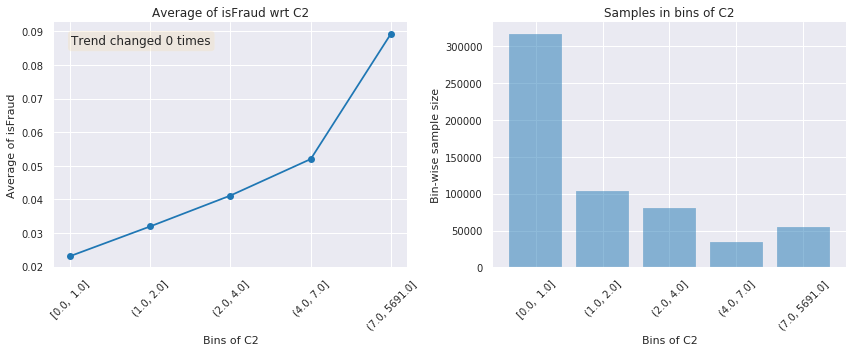

--------------------------------------------------------------------------------------------------------------


                                             Plots for C3                                             


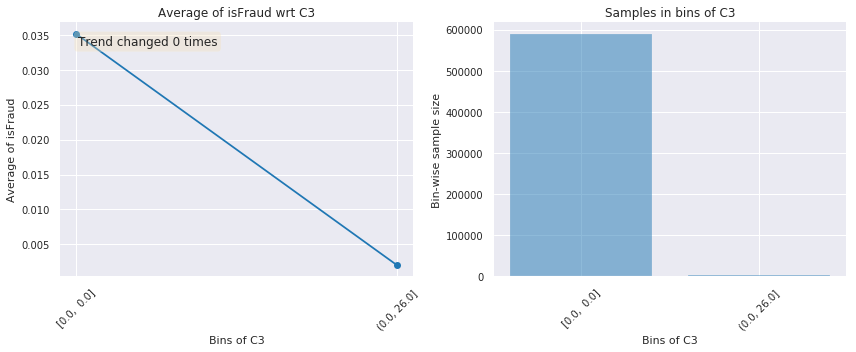

--------------------------------------------------------------------------------------------------------------


                                             Plots for C4                                             


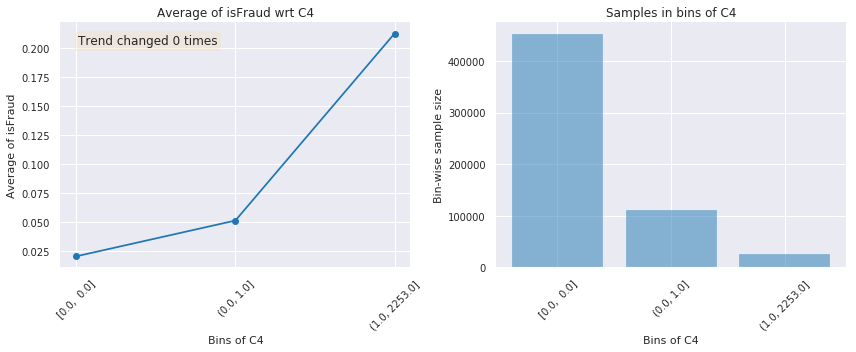

--------------------------------------------------------------------------------------------------------------


                                             Plots for C5                                             


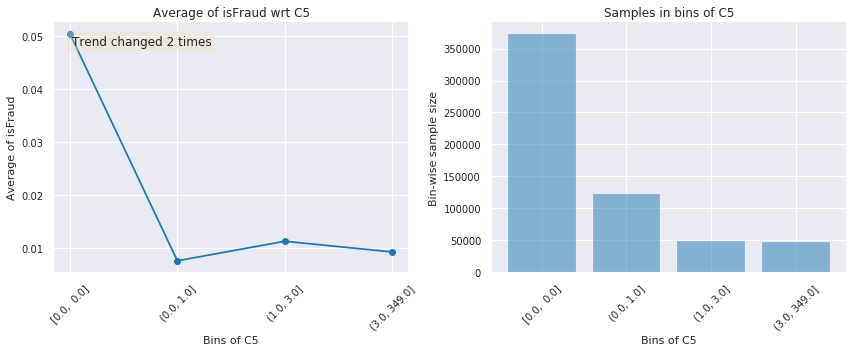

--------------------------------------------------------------------------------------------------------------


                                             Plots for C6                                             


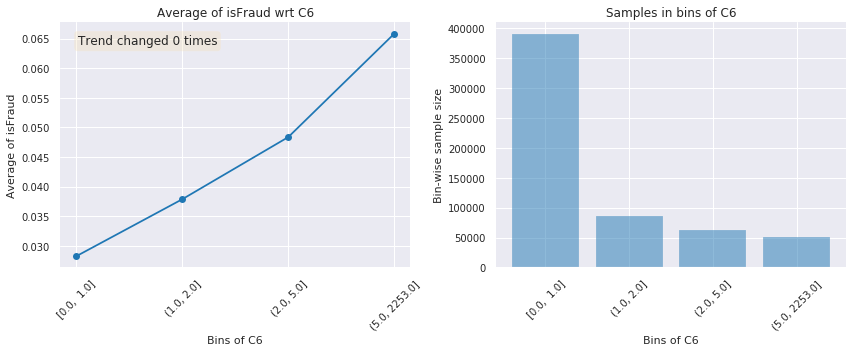

--------------------------------------------------------------------------------------------------------------


                                             Plots for C7                                             


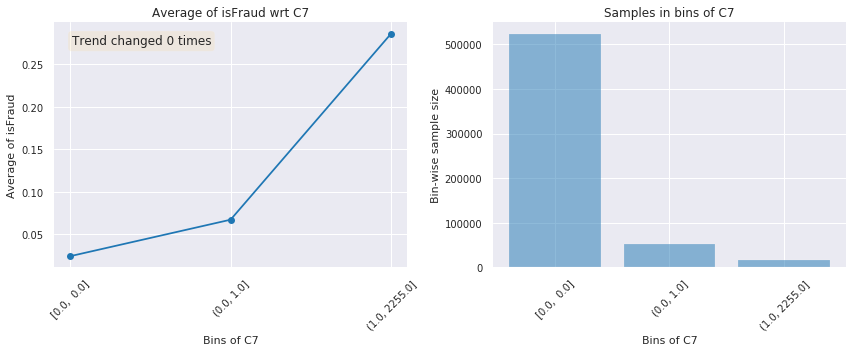

--------------------------------------------------------------------------------------------------------------


                                             Plots for C8                                             


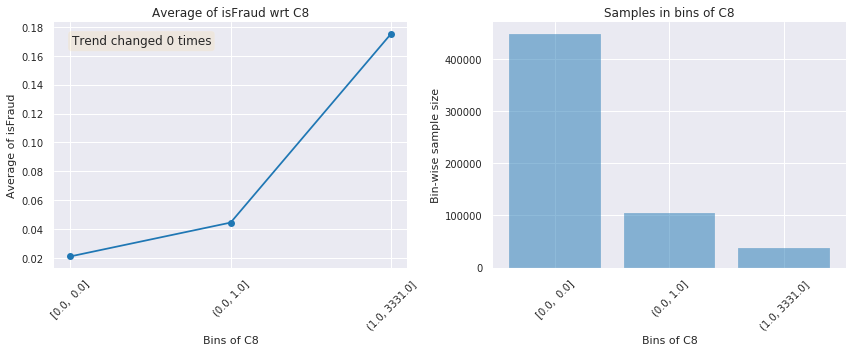

--------------------------------------------------------------------------------------------------------------


                                             Plots for C9                                             


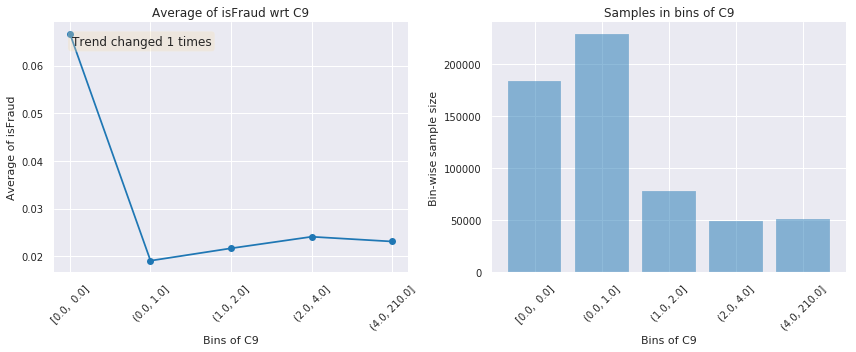

--------------------------------------------------------------------------------------------------------------


                                            Plots for C10                                             


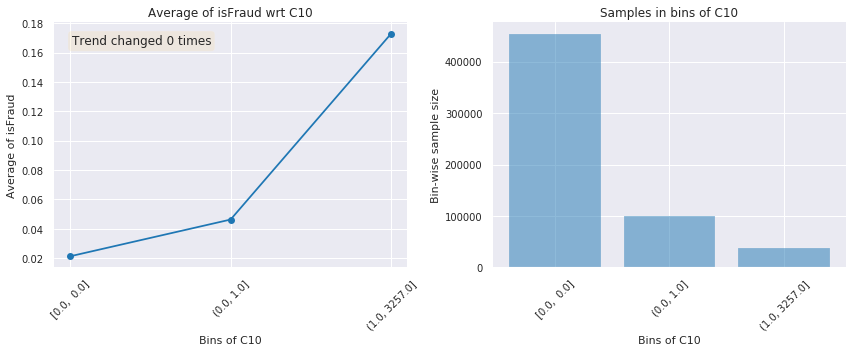

--------------------------------------------------------------------------------------------------------------


                                            Plots for C11                                             


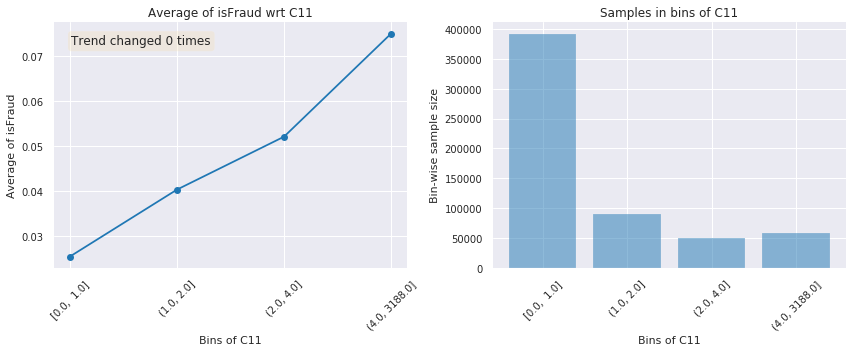

--------------------------------------------------------------------------------------------------------------


                                            Plots for C12                                             


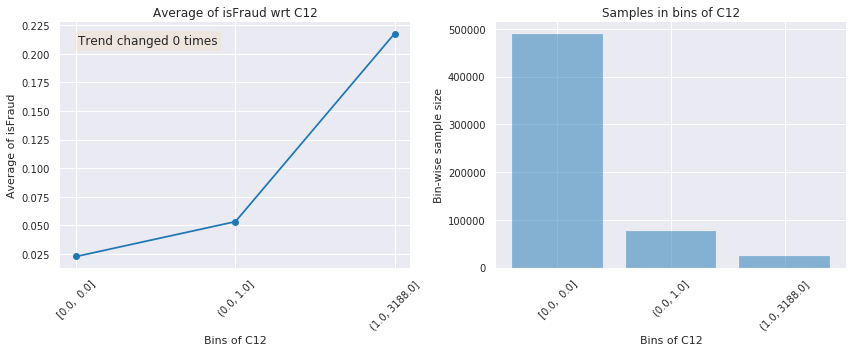

--------------------------------------------------------------------------------------------------------------


                                            Plots for C13                                             


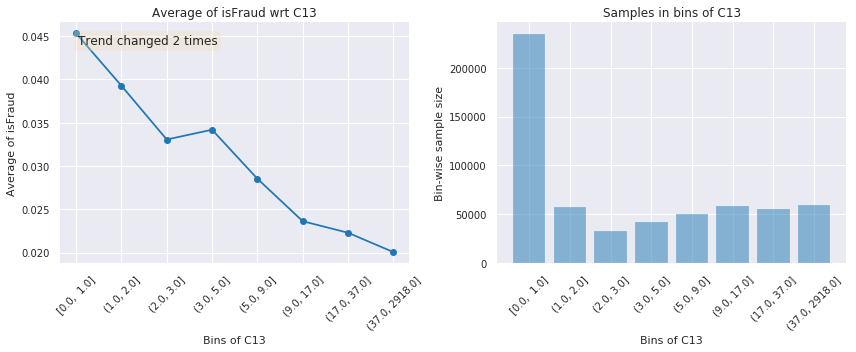

--------------------------------------------------------------------------------------------------------------


                                            Plots for C14                                             


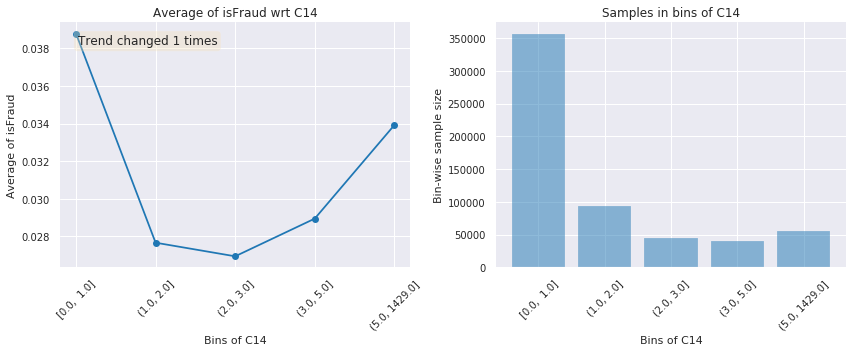

--------------------------------------------------------------------------------------------------------------




In [50]:
get_univariate_plots(data=train_transaction_data[C_cols + [target_col]], 
                     target_col=target_col, 
                     bins=10,
                     features_list=C_cols)

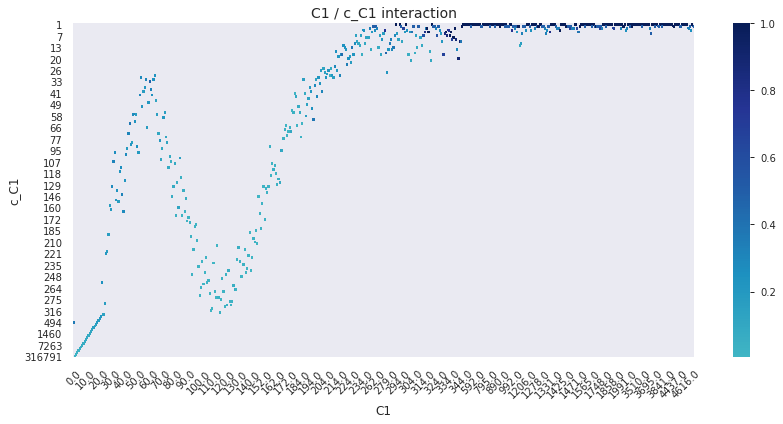

-----------------------------------------------------------------------------------------------------




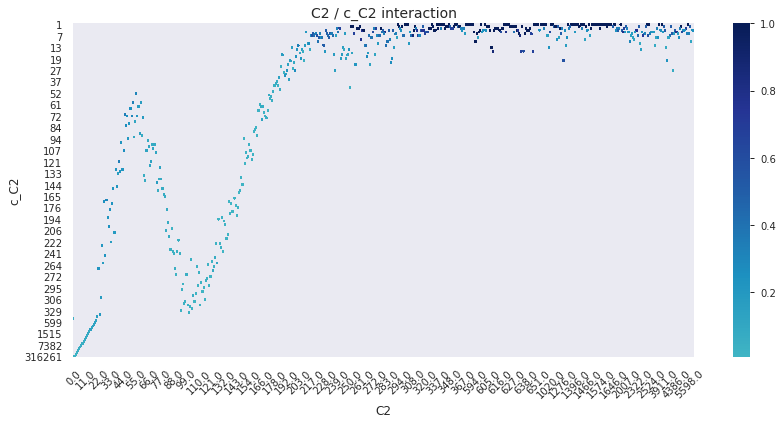

-----------------------------------------------------------------------------------------------------




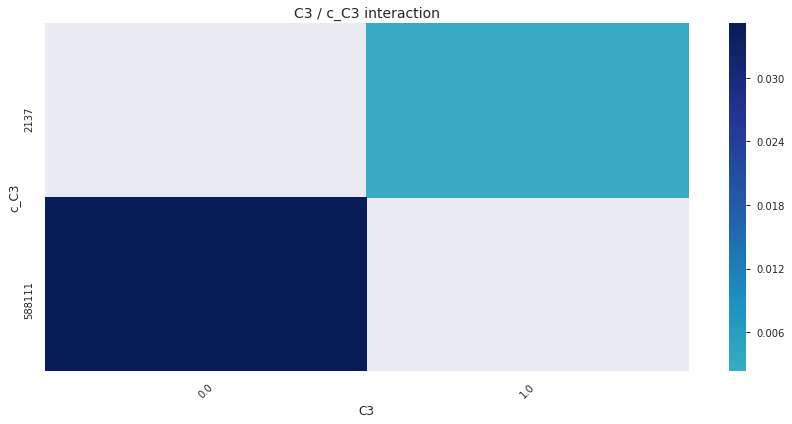

-----------------------------------------------------------------------------------------------------




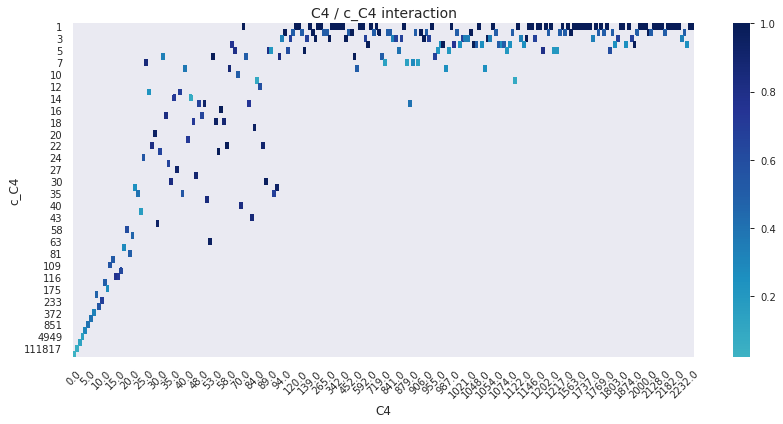

-----------------------------------------------------------------------------------------------------




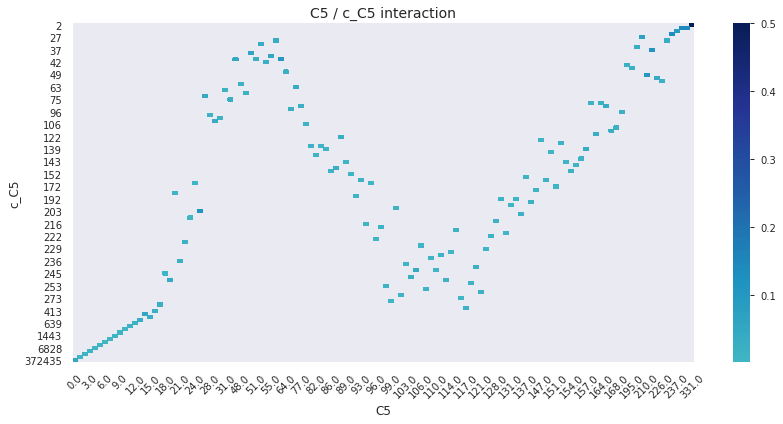

-----------------------------------------------------------------------------------------------------




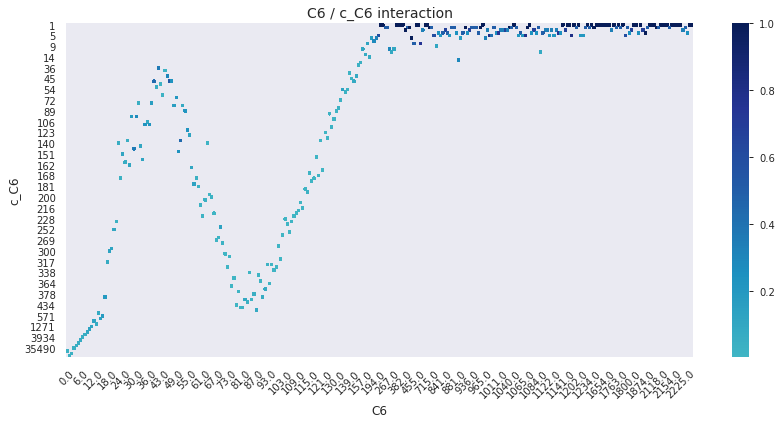

-----------------------------------------------------------------------------------------------------




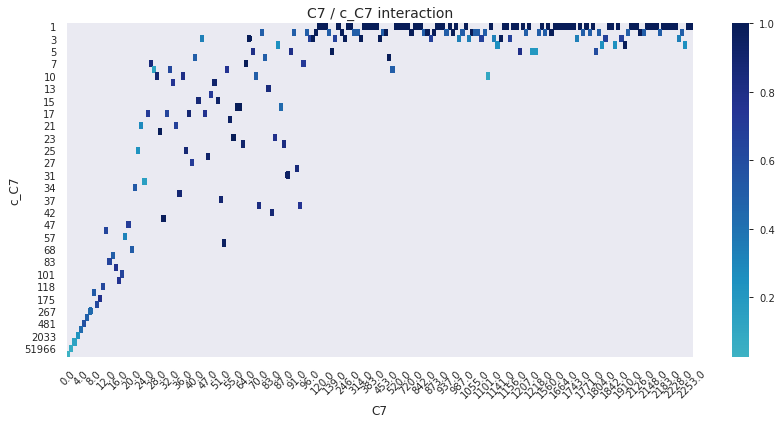

-----------------------------------------------------------------------------------------------------




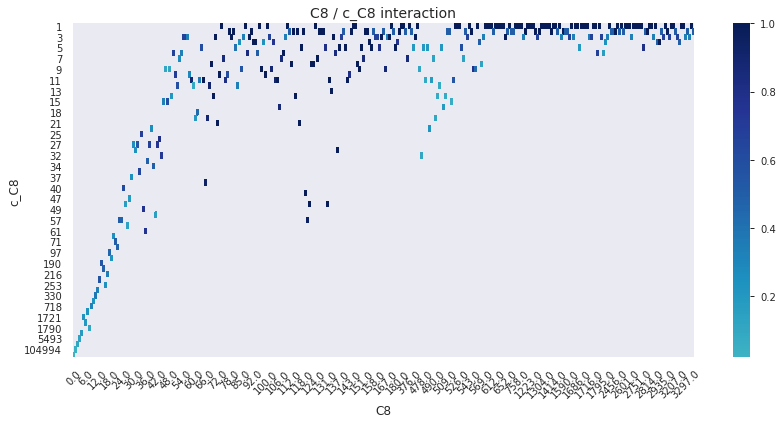

-----------------------------------------------------------------------------------------------------




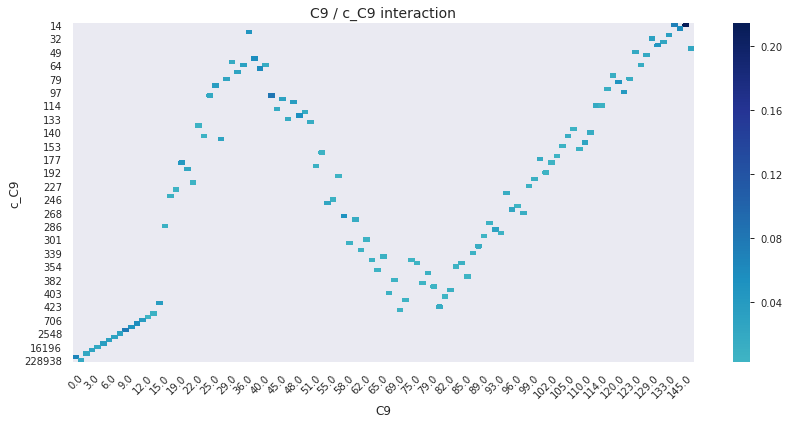

-----------------------------------------------------------------------------------------------------




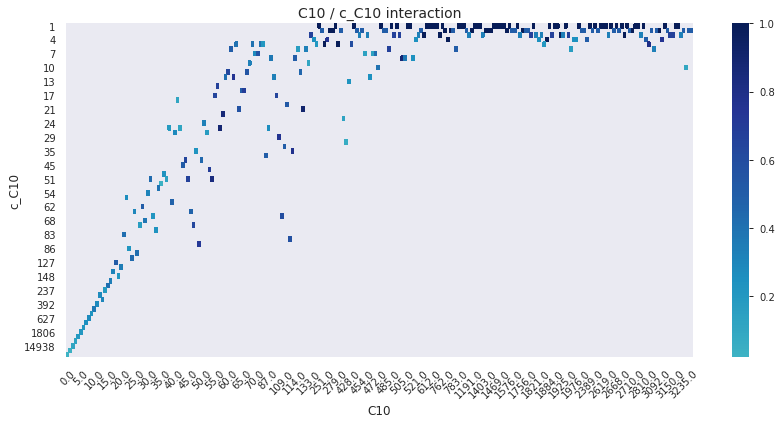

-----------------------------------------------------------------------------------------------------




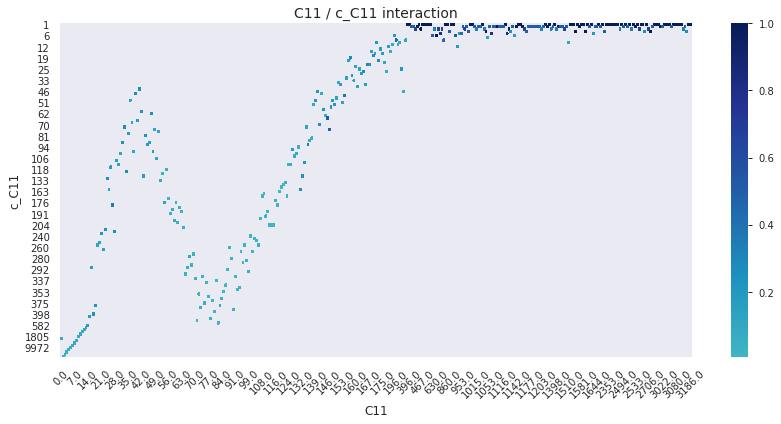

-----------------------------------------------------------------------------------------------------




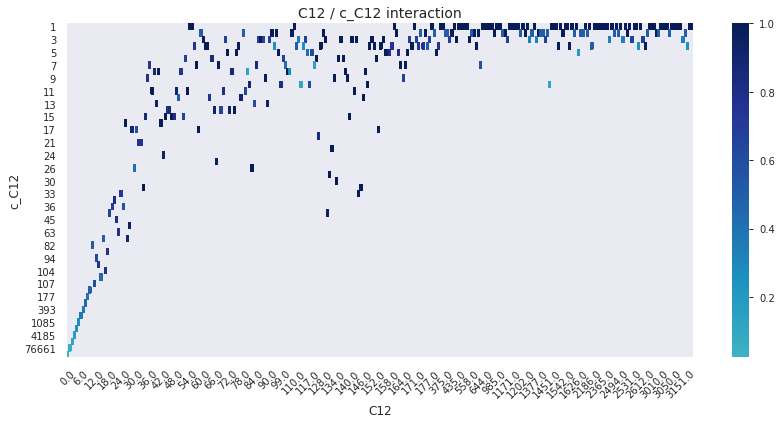

-----------------------------------------------------------------------------------------------------




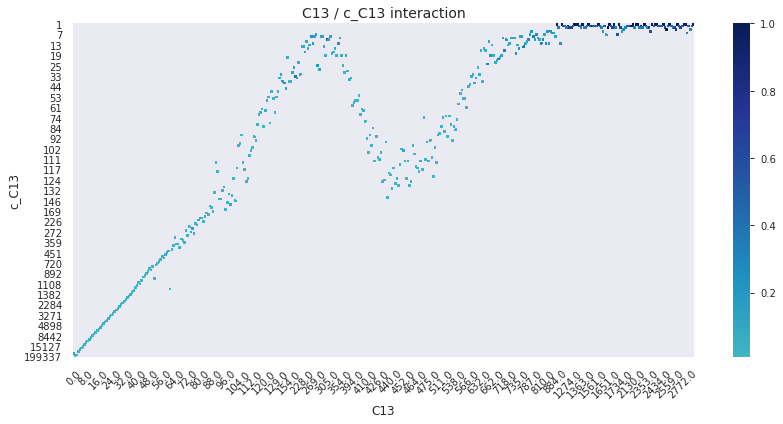

-----------------------------------------------------------------------------------------------------




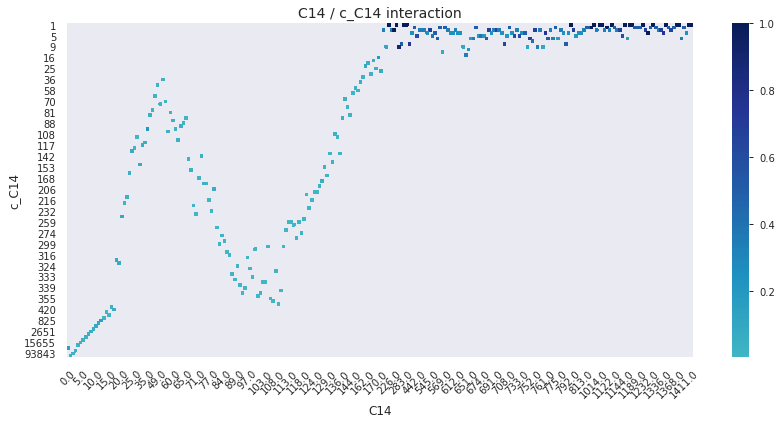

-----------------------------------------------------------------------------------------------------




In [23]:
continue_C_cols = [i for i in C_cols if str(train_transaction_data[i].dtype) not in ['object', 'category']]
utils_features_plots.plot_feature_freq(train_transaction_data, continue_C_cols, target_col)


In [22]:
cs_res_df = pd.DataFrame(columns=['col_name', 'auc'])
for idx, c in enumerate(C_cols):
    cs_res_df.loc[idx, 'col_name'] = c
    cs_res_df.loc[idx, 'auc'] = covariate_shift(train_data=train_transaction_data, 
                                                test_data=test_transaction_data, 
                                                feature=c, 
                                                seed=42)
cs_res_df    

col_name       auc
0        C1  0.517611
1        C2  0.518776
2        C3  0.510645
3        C4  0.518614
4        C5  0.517479
5        C6   0.51444
6        C7  0.512804
7        C8  0.521169
8        C9  0.516838
9       C10  0.523449
10      C11  0.522537
11      C12  0.553949
12      C13   0.51863
13      C14  0.514293

* ***M columns***

In [24]:
train_transaction_data[M_cols].head()

M1   M2   M3   M4   M5   M6   M7   M8   M9
0    T    T    T   M2    F    T  NaN  NaN  NaN
1  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2    T    T    T   M0    F    F    F    F    F
3  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [25]:
utils_statistic.resumetable(train_transaction_data[M_cols])

Dataset Shape: (590540, 9)


Name  dtypes  Missing  Missing%  Uniques First Value Second Value  \
0   M1  object   271100   45.9071        2           T          NaN   
1   M2  object   271100   45.9071        2           T          NaN   
2   M3  object   271100   45.9071        2           T          NaN   
3   M4  object   281444   47.6588        3          M2           M0   
4   M5  object   350482   59.3494        2           F            T   
5   M6  object   169360   28.6788        2           T            T   
6   M7  object   346265   58.6353        2         NaN          NaN   
7   M8  object   346252   58.6331        2         NaN          NaN   
8   M9  object   346252   58.6331        2         NaN          NaN   

  Third Value  Entropy  
0           T     0.00  
1           T     0.49  
2           T     0.75  
3          M0     1.31  
4           F     0.99  
5           F     1.00  
6           F     0.57  
7           F     0.95  
8           F     0.63

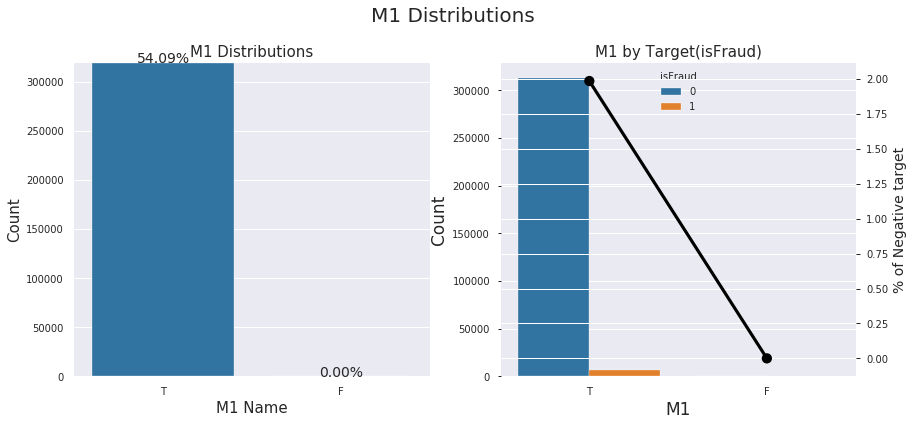

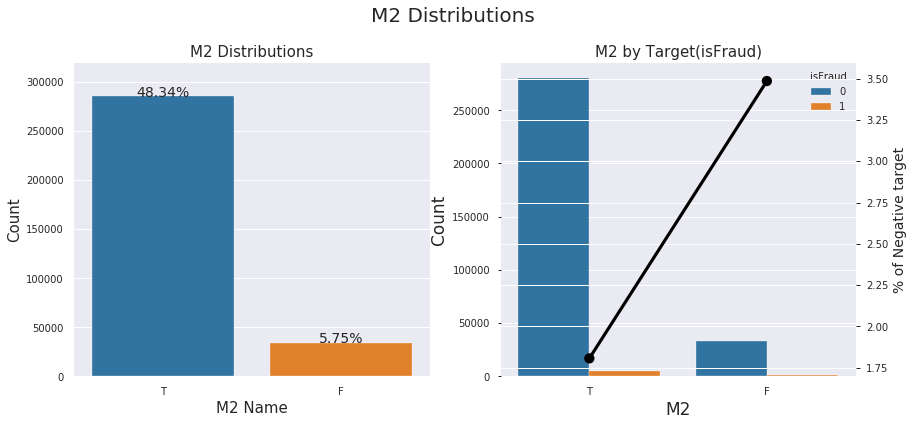

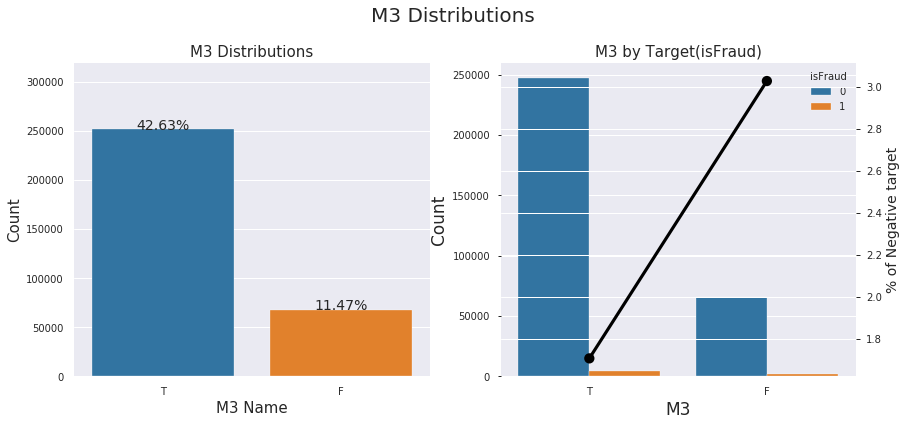

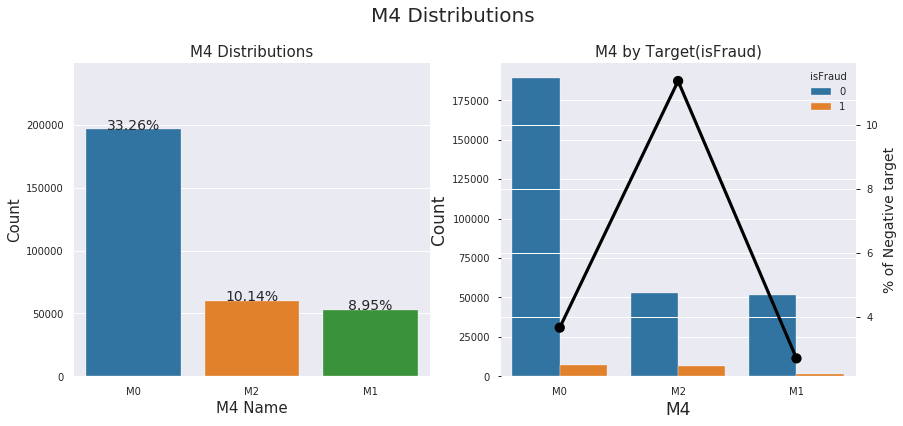

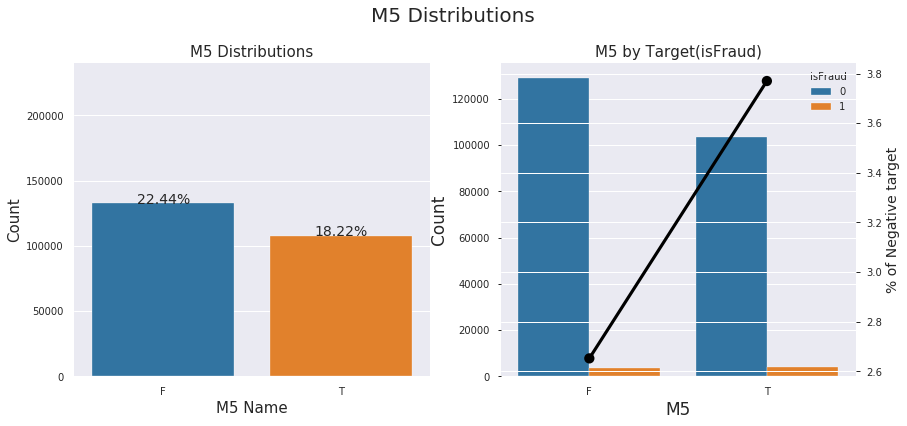

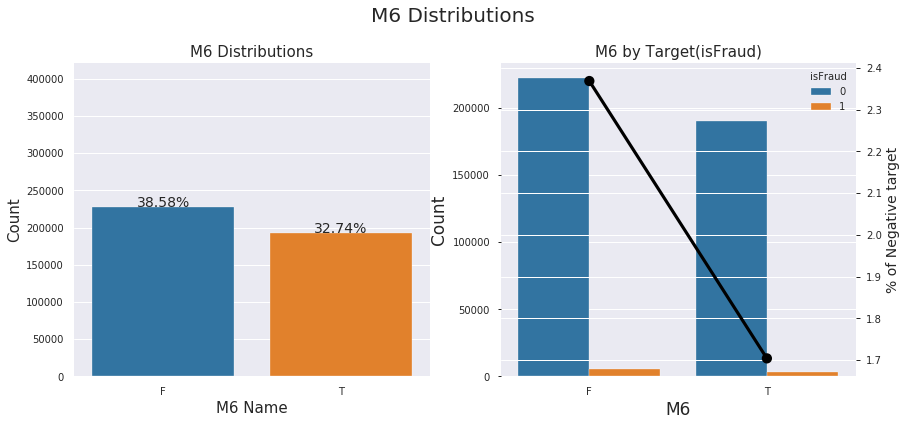

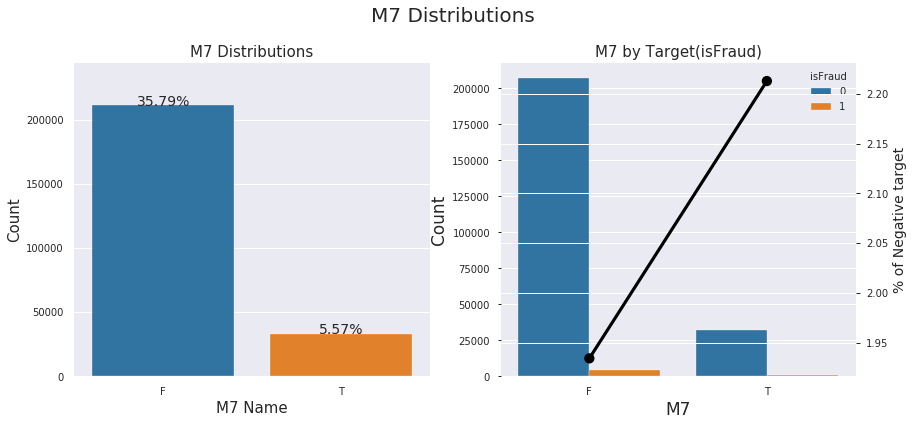

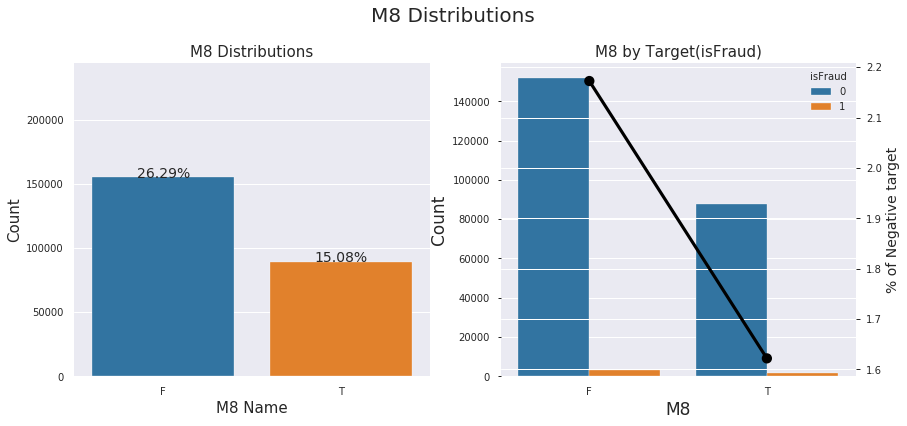

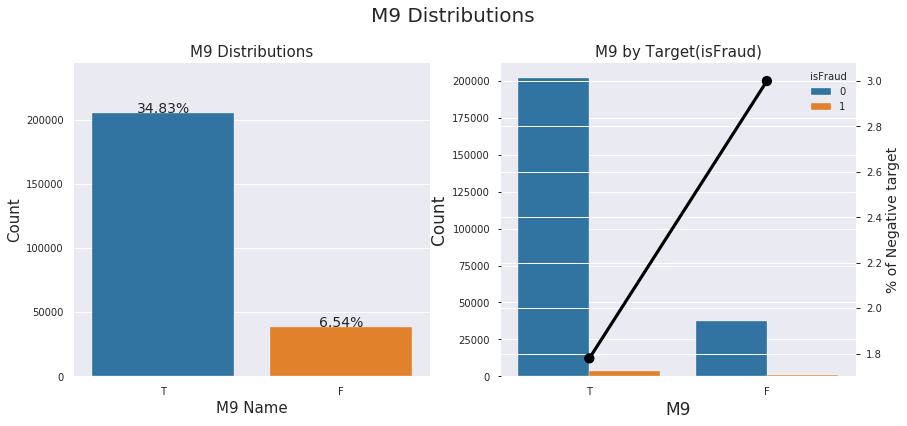

In [26]:
for c in M_cols:
    utils_features_plots.plot_cate_feature_distribtion(train_transaction_data, c, target_col)

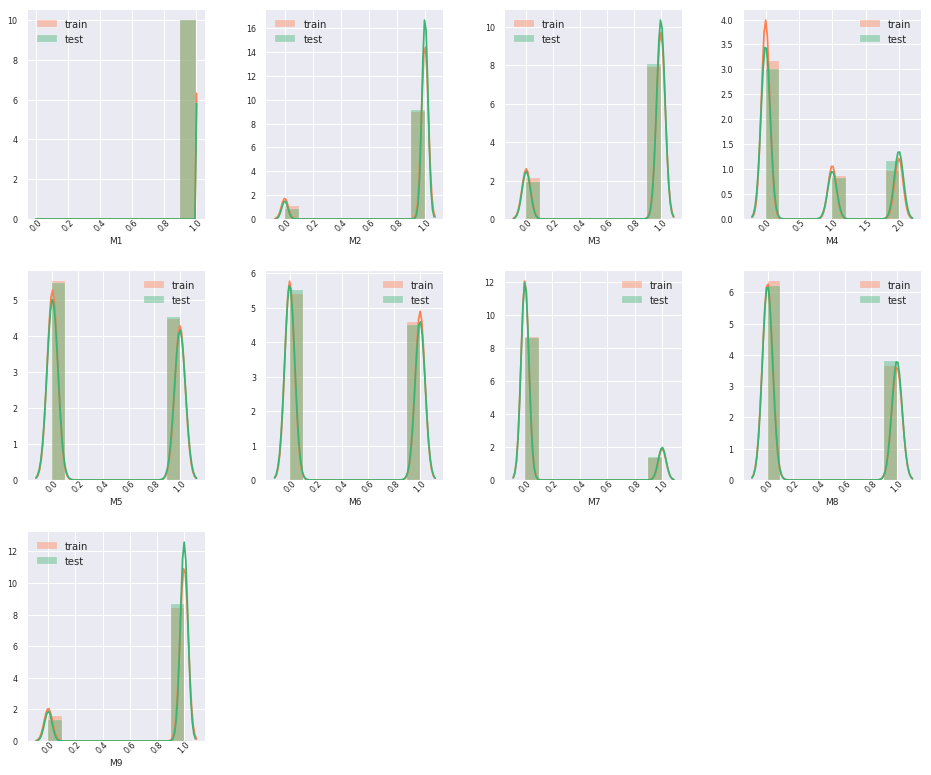

In [53]:
plot_feature_histograms(
    df1=train_transaction_data, 
    df2=test_transaction_data, 
    label1='train',
    label2='test', 
    features=M_cols)

In [51]:
cs_res_df = pd.DataFrame(columns=['col_name', 'auc'])
for idx, c in enumerate(M_cols):
    cs_res_df.loc[idx, 'col_name'] = c
    cs_res_df.loc[idx, 'auc'] = covariate_shift(train_data=train_transaction_data, 
                                                test_data=test_transaction_data, 
                                                feature=c, 
                                                seed=42)
cs_res_df    

col_name       auc
0       M1  0.555748
1       M2  0.559854
2       M3  0.559084
3       M4  0.513987
4       M5  0.510406
5       M6    0.5155
6       M7  0.562454
7       M8  0.563606
8       M9  0.565068

* ***V columns***

In [17]:
utils_statistic.resumetable(train_transaction_data[V_cols[:50]])

Dataset Shape: (590540, 50)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0    V1  float64   279287   47.2935        2          1.0           NaN   
1    V2  float64   279287   47.2935        9          1.0           NaN   
2    V3  float64   279287   47.2935       10          1.0           NaN   
3    V4  float64   279287   47.2935        7          1.0           NaN   
4    V5  float64   279287   47.2935        7          1.0           NaN   
5    V6  float64   279287   47.2935       10          1.0           NaN   
6    V7  float64   279287   47.2935       10          1.0           NaN   
7    V8  float64   279287   47.2935        9          1.0           NaN   
8    V9  float64   279287   47.2935        9          1.0           NaN   
9   V10  float64   279287   47.2935        5          0.0           NaN   
10  V11  float64   279287   47.2935        6          0.0           NaN   
11  V12  float64    76073   12.8819        4          1.0           0.0   
12  V13  float64    76073   12.8819        7          1.0           0.0   
13  V14  float64    76073   12.8819        2          1.0           1.0   
14  V15  float64    76073   12.8819        8          0.0           0.0   
15  V16  float64    76073   12.8819       15          0.0           0.0   
16  V17  float64    76073   12.8819       16          0.0           0.0   
17  V18  float64    76073   12.8819       16          0.0           0.0   
18  V19  float64    76073   12.8819        8          1.0           1.0   
19  V20  float64    76073   12.8819       15          1.0           1.0   
20  V21  float64    76073   12.8819        6          0.0           0.0   
21  V22  float64    76073   12.8819        9          0.0           0.0   
22  V23  float64    76073   12.8819       14          1.0           1.0   
23  V24  float64    76073   12.8819       14          1.0           1.0   
24  V25  float64    76073   12.8819        7          1.0           1.0   
25  V26  float64    76073   12.8819       13          1.0           1.0   
26  V27  float64    76073   12.8819        4          0.0           0.0   
27  V28  float64    76073   12.8819        4          0.0           0.0   
28  V29  float64    76073   12.8819        6          0.0           0.0   
29  V30  float64    76073   12.8819        8          0.0           0.0   
30  V31  float64    76073   12.8819        8          0.0           0.0   
31  V32  float64    76073   12.8819       15          0.0           0.0   
32  V33  float64    76073   12.8819        7          0.0           0.0   
33  V34  float64    76073   12.8819       13          0.0           0.0   
34  V35  float64   168969   28.6126        4          NaN           0.0   
35  V36  float64   168969   28.6126        6          NaN           0.0   
36  V37  float64   168969   28.6126       55          NaN           1.0   
37  V38  float64   168969   28.6126       55          NaN           1.0   
38  V39  float64   168969   28.6126       16          NaN           0.0   
39  V40  float64   168969   28.6126       18          NaN           0.0   
40  V41  float64   168969   28.6126        2          NaN           1.0   
41  V42  float64   168969   28.6126        9          NaN           0.0   
42  V43  float64   168969   28.6126        9          NaN           0.0   
43  V44  float64   168969   28.6126       49          NaN           1.0   
44  V45  float64   168969   28.6126       49          NaN           1.0   
45  V46  float64   168969   28.6126        7          NaN           1.0   
46  V47  float64   168969   28.6126        9          NaN           1.0   
47  V48  float64   168969   28.6126        6          NaN           0.0   
48  V49  float64   168969   28.6126        6          NaN           0.0   
49  V50  float64   168969   28.6126        6          NaN           0.0   

    Third Value  Entropy  
0           1.0     0.00  
1           1.0     0.27  
2           1.0     0.40  
3           1.0     0.86  
4           1.0     0.95  
5           1.0

In [18]:
utils_statistic.resumetable(train_transaction_data[V_cols[50:100]])

Dataset Shape: (590540, 50)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0    V51  float64   168969   28.6126        7          NaN           0.0   
1    V52  float64   168969   28.6126        9          NaN           0.0   
2    V53  float64    77096   13.0552        6          1.0           0.0   
3    V54  float64    77096   13.0552        7          1.0           0.0   
4    V55  float64    77096   13.0552       18          1.0           1.0   
5    V56  float64    77096   13.0552       52          1.0           1.0   
6    V57  float64    77096   13.0552        7          0.0           0.0   
7    V58  float64    77096   13.0552       11          0.0           0.0   
8    V59  float64    77096   13.0552       17          0.0           0.0   
9    V60  float64    77096   13.0552       17          0.0           0.0   
10   V61  float64    77096   13.0552        7          1.0           1.0   
11   V62  float64    77096   13.0552       11          1.0           1.0   
12   V63  float64    77096   13.0552        8          0.0           0.0   
13   V64  float64    77096   13.0552        8          0.0           0.0   
14   V65  float64    77096   13.0552        2          1.0           1.0   
15   V66  float64    77096   13.0552        8          1.0           1.0   
16   V67  float64    77096   13.0552        9          1.0           1.0   
17   V68  float64    77096   13.0552        3          0.0           0.0   
18   V69  float64    77096   13.0552        6          0.0           0.0   
19   V70  float64    77096   13.0552        7          0.0           0.0   
20   V71  float64    77096   13.0552        7          0.0           0.0   
21   V72  float64    77096   13.0552       11          0.0           0.0   
22   V73  float64    77096   13.0552        8          0.0           0.0   
23   V74  float64    77096   13.0552        9          0.0           0.0   
24   V75  float64    89164   15.0987        5          1.0           0.0   
25   V76  float64    89164   15.0987        7          1.0           0.0   
26   V77  float64    89164   15.0987       31          1.0           1.0   
27   V78  float64    89164   15.0987       32          1.0           1.0   
28   V79  float64    89164   15.0987        8          0.0           0.0   
29   V80  float64    89164   15.0987       20          0.0           0.0   
30   V81  float64    89164   15.0987       20          0.0           0.0   
31   V82  float64    89164   15.0987        8          0.0           1.0   
32   V83  float64    89164   15.0987        8          0.0           1.0   
33   V84  float64    89164   15.0987        8          0.0           0.0   
34   V85  float64    89164   15.0987        8          0.0           0.0   
35   V86  float64    89164   15.0987       31          1.0           1.0   
36   V87  float64    89164   15.0987       31          1.0           1.0   
37   V88  float64    89164   15.0987        2          1.0           1.0   
38   V89  float64    89164   15.0987        3          0.0           0.0   
39   V90  float64    89164   15.0987        6          0.0           0.0   
40   V91  float64    89164   15.0987        7          0.0           0.0   
41   V92  float64    89164   15.0987        8          0.0           0.0   
42   V93  float64    89164   15.0987        8          0.0           0.0   
43   V94  float64    89164   15.0987        3          0.0           0.0   
44   V95  float64      314    0.0532      881          0.0           0.0   
45   V96  float64      314    0.0532     1410          1.0           0.0   
46   V97  float64      314    0.0532      976          0.0           0.0   
47   V98  float64      314    0.0532       13          0.0           0.0   
48   V99  float64      314    0.0532       89          0.0           0.0   
49  V100  float64      314    0.0532       29          0.0           0.0   

    Third Value  Entropy  
0           0.0     0.69  
1           0.0     0.73  
2           1.0     1.05  
3           1.0    

In [19]:
utils_statistic.resumetable(train_transaction_data[V_cols[100:150]])

Dataset Shape: (590540, 50)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0   V101  float64      314    0.0532      870          0.0           0.0   
1   V102  float64      314    0.0532     1285          1.0           0.0   
2   V103  float64      314    0.0532      928          0.0           0.0   
3   V104  float64      314    0.0532       16          0.0           0.0   
4   V105  float64      314    0.0532      100          0.0           0.0   
5   V106  float64      314    0.0532       56          0.0           0.0   
6   V107  float64      314    0.0532        2          1.0           1.0   
7   V108  float64      314    0.0532        8          1.0           1.0   
8   V109  float64      314    0.0532        8          1.0           1.0   
9   V110  float64      314    0.0532        8          1.0           1.0   
10  V111  float64      314    0.0532       10          1.0           1.0   
11  V112  float64      314    0.0532       10          1.0           1.0   
12  V113  float64      314    0.0532       10          1.0           1.0   
13  V114  float64      314    0.0532        7          1.0           1.0   
14  V115  float64      314    0.0532        7          1.0           1.0   
15  V116  float64      314    0.0532        7          1.0           1.0   
16  V117  float64      314    0.0532        4          1.0           1.0   
17  V118  float64      314    0.0532        4          1.0           1.0   
18  V119  float64      314    0.0532        4          1.0           1.0   
19  V120  float64      314    0.0532        4          1.0           1.0   
20  V121  float64      314    0.0532        4          1.0           1.0   
21  V122  float64      314    0.0532        4          1.0           1.0   
22  V123  float64      314    0.0532       14          1.0           1.0   
23  V124  float64      314    0.0532       14          1.0           1.0   
24  V125  float64      314    0.0532       14          1.0           1.0   
25  V126  float64      314    0.0532    10299          0.0           0.0   
26  V127  float64      314    0.0532    24414        117.0           0.0   
27  V128  float64      314    0.0532    14507          0.0           0.0   
28  V129  float64      314    0.0532     1968          0.0           0.0   
29  V130  float64      314    0.0532    12332          0.0           0.0   
30  V131  float64      314    0.0532     4444          0.0           0.0   
31  V132  float64      314    0.0532     6560          0.0           0.0   
32  V133  float64      314    0.0532     9949        117.0           0.0   
33  V134  float64      314    0.0532     8178          0.0           0.0   
34  V135  float64      314    0.0532     3724          0.0           0.0   
35  V136  float64      314    0.0532     4852          0.0           0.0   
36  V137  float64      314    0.0532     4252          0.0           0.0   
37  V138  float64   508595   86.1237       23          NaN           NaN   
38  V139  float64   508595   86.1237       34          NaN           NaN   
39  V140  float64   508595   86.1237       34          NaN           NaN   
40  V141  float64   508595   86.1237        6          NaN           NaN   
41  V142  float64   508595   86.1237       10          NaN           NaN   
42  V143  float64   508589   86.1227      870          NaN           NaN   
43  V144  float64   508589   86.1227       63          NaN           NaN   
44  V145  float64   508589   86.1227      260          NaN           NaN   
45  V146  float64   508595   86.1237       25          NaN           NaN   
46  V147  float64   508595   86.1237       27          NaN           NaN   
47  V148  float64   508595   86.1237       21          NaN           NaN   
48  V149  float64   508595   86.1237       21          NaN           NaN   
49  V150  float64   508589   86.1227     1996          NaN           NaN   

    Third Value  Entropy  
0           0.0     0.45  
1           0.0     0.73  
2           0.0     0.57  
3           0.0    

In [20]:
utils_statistic.resumetable(train_transaction_data[V_cols[150:200]])

Dataset Shape: (590540, 50)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0   V151  float64   508589   86.1227       56          NaN           NaN   
1   V152  float64   508589   86.1227       39          NaN           NaN   
2   V153  float64   508595   86.1237       19          NaN           NaN   
3   V154  float64   508595   86.1237       19          NaN           NaN   
4   V155  float64   508595   86.1237       25          NaN           NaN   
5   V156  float64   508595   86.1237       25          NaN           NaN   
6   V157  float64   508595   86.1237       25          NaN           NaN   
7   V158  float64   508595   86.1237       25          NaN           NaN   
8   V159  float64   508589   86.1227     6663          NaN           NaN   
9   V160  float64   508589   86.1227     9621          NaN           NaN   
10  V161  float64   508595   86.1237       79          NaN           NaN   
11  V162  float64   508595   86.1237      185          NaN           NaN   
12  V163  float64   508595   86.1237      106          NaN           NaN   
13  V164  float64   508589   86.1227     1978          NaN           NaN   
14  V165  float64   508589   86.1227     2547          NaN           NaN   
15  V166  float64   508589   86.1227      987          NaN           NaN   
16  V167  float64   450909   76.3554      873          NaN           NaN   
17  V168  float64   450909   76.3554      965          NaN           NaN   
18  V169  float64   450721   76.3235       20          NaN           NaN   
19  V170  float64   450721   76.3235       49          NaN           NaN   
20  V171  float64   450721   76.3235       62          NaN           NaN   
21  V172  float64   450909   76.3554       32          NaN           NaN   
22  V173  float64   450909   76.3554        8          NaN           NaN   
23  V174  float64   450721   76.3235        9          NaN           NaN   
24  V175  float64   450721   76.3235       15          NaN           NaN   
25  V176  float64   450909   76.3554       49          NaN           NaN   
26  V177  float64   450909   76.3554      862          NaN           NaN   
27  V178  float64   450909   76.3554     1236          NaN           NaN   
28  V179  float64   450909   76.3554      921          NaN           NaN   
29  V180  float64   450721   76.3235       84          NaN           NaN   
30  V181  float64   450909   76.3554       25          NaN           NaN   
31  V182  float64   450909   76.3554       84          NaN           NaN   
32  V183  float64   450909   76.3554       42          NaN           NaN   
33  V184  float64   450721   76.3235       17          NaN           NaN   
34  V185  float64   450721   76.3235       32          NaN           NaN   
35  V186  float64   450909   76.3554       39          NaN           NaN   
36  V187  float64   450909   76.3554      215          NaN           NaN   
37  V188  float64   450721   76.3235       31          NaN           NaN   
38  V189  float64   450721   76.3235       31          NaN           NaN   
39  V190  float64   450909   76.3554       43          NaN           NaN   
40  V191  float64   450909   76.3554       22          NaN           NaN   
41  V192  float64   450909   76.3554       45          NaN           NaN   
42  V193  float64   450909   76.3554       38          NaN           NaN   
43  V194  float64   450721   76.3235        8          NaN           NaN   
44  V195  float64   450721   76.3235       17          NaN           NaN   
45  V196  float64   450909   76.3554       39          NaN           NaN   
46  V197  float64   450721   76.3235       15          NaN           NaN   
47  V198  float64   450721   76.3235       22          NaN           NaN   
48  V199  float64   450909   76.3554       46          NaN           NaN   
49  V200  float64   450721   76.3235       46          NaN           NaN   

    Third Value  Entropy  
0           NaN     1.25  
1           NaN     1.22  
2           NaN     0.94  
3           NaN    

In [21]:
utils_statistic.resumetable(train_transaction_data[V_cols[200:250]])

Dataset Shape: (590540, 50)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0   V201  float64   450721   76.3235       56          NaN           NaN   
1   V202  float64   450909   76.3554    10970          NaN           NaN   
2   V203  float64   450909   76.3554    14951          NaN           NaN   
3   V204  float64   450909   76.3554    12858          NaN           NaN   
4   V205  float64   450909   76.3554     2240          NaN           NaN   
5   V206  float64   450909   76.3554     1780          NaN           NaN   
6   V207  float64   450909   76.3554     3246          NaN           NaN   
7   V208  float64   450721   76.3235     2552          NaN           NaN   
8   V209  float64   450721   76.3235     3451          NaN           NaN   
9   V210  float64   450721   76.3235     2836          NaN           NaN   
10  V211  float64   450909   76.3554     7624          NaN           NaN   
11  V212  float64   450909   76.3554     8868          NaN           NaN   
12  V213  float64   450909   76.3554     8317          NaN           NaN   
13  V214  float64   450909   76.3554     2282          NaN           NaN   
14  V215  float64   450909   76.3554     2747          NaN           NaN   
15  V216  float64   450909   76.3554     2532          NaN           NaN   
16  V217  float64   460110   77.9134      304          NaN           NaN   
17  V218  float64   460110   77.9134      401          NaN           NaN   
18  V219  float64   460110   77.9134      379          NaN           NaN   
19  V220  float64   449124   76.0531       26          NaN           NaN   
20  V221  float64   449124   76.0531       77          NaN           NaN   
21  V222  float64   449124   76.0531       76          NaN           NaN   
22  V223  float64   460110   77.9134       17          NaN           NaN   
23  V224  float64   460110   77.9134       79          NaN           NaN   
24  V225  float64   460110   77.9134       35          NaN           NaN   
25  V226  float64   460110   77.9134       81          NaN           NaN   
26  V227  float64   449124   76.0531       50          NaN           NaN   
27  V228  float64   460110   77.9134       55          NaN           NaN   
28  V229  float64   460110   77.9134       91          NaN           NaN   
29  V230  float64   460110   77.9134       66          NaN           NaN   
30  V231  float64   460110   77.9134      294          NaN           NaN   
31  V232  float64   460110   77.9134      338          NaN           NaN   
32  V233  float64   460110   77.9134      333          NaN           NaN   
33  V234  float64   449124   76.0531      122          NaN           NaN   
34  V235  float64   460110   77.9134       24          NaN           NaN   
35  V236  float64   460110   77.9134       46          NaN           NaN   
36  V237  float64   460110   77.9134       40          NaN           NaN   
37  V238  float64   449124   76.0531       24          NaN           NaN   
38  V239  float64   449124   76.0531       24          NaN           NaN   
39  V240  float64   460110   77.9134        6          NaN           NaN   
40  V241  float64   460110   77.9134        5          NaN           NaN   
41  V242  float64   460110   77.9134       21          NaN           NaN   
42  V243  float64   460110   77.9134       43          NaN           NaN   
43  V244  float64   460110   77.9134       23          NaN           NaN   
44  V245  float64   449124   76.0531       58          NaN           NaN   
45  V246  float64   460110   77.9134       46          NaN           NaN   
46  V247  float64   460110   77.9134       19          NaN           NaN   
47  V248  float64   460110   77.9134       23          NaN           NaN   
48  V249  float64   460110   77.9134       23          NaN           NaN   
49  V250  float64   449124   76.0531       19          NaN           NaN   

    Third Value  Entropy  
0           NaN     1.00  
1           NaN     3.27  
2           NaN     4.13  
3           NaN    

In [22]:
utils_statistic.resumetable(train_transaction_data[V_cols[250:300]])

Dataset Shape: (590540, 50)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0   V251  float64   449124   76.0531       19          NaN           NaN   
1   V252  float64   460110   77.9134       25          NaN           NaN   
2   V253  float64   460110   77.9134       66          NaN           NaN   
3   V254  float64   460110   77.9134       45          NaN           NaN   
4   V255  float64   449124   76.0531       46          NaN           NaN   
5   V256  float64   449124   76.0531       48          NaN           NaN   
6   V257  float64   460110   77.9134       49          NaN           NaN   
7   V258  float64   460110   77.9134       67          NaN           NaN   
8   V259  float64   449124   76.0531       68          NaN           NaN   
9   V260  float64   460110   77.9134        9          NaN           NaN   
10  V261  float64   460110   77.9134       41          NaN           NaN   
11  V262  float64   460110   77.9134       21          NaN           NaN   
12  V263  float64   460110   77.9134    10422          NaN           NaN   
13  V264  float64   460110   77.9134    13358          NaN           NaN   
14  V265  float64   460110   77.9134    11757          NaN           NaN   
15  V266  float64   460110   77.9134     2178          NaN           NaN   
16  V267  float64   460110   77.9134     3616          NaN           NaN   
17  V268  float64   460110   77.9134     2756          NaN           NaN   
18  V269  float64   460110   77.9134      151          NaN           NaN   
19  V270  float64   449124   76.0531     2340          NaN           NaN   
20  V271  float64   449124   76.0531     2787          NaN           NaN   
21  V272  float64   449124   76.0531     2507          NaN           NaN   
22  V273  float64   460110   77.9134     7177          NaN           NaN   
23  V274  float64   460110   77.9134     8315          NaN           NaN   
24  V275  float64   460110   77.9134     7776          NaN           NaN   
25  V276  float64   460110   77.9134     2263          NaN           NaN   
26  V277  float64   460110   77.9134     2540          NaN           NaN   
27  V278  float64   460110   77.9134     2398          NaN           NaN   
28  V279  float64       12    0.0020      881          0.0           0.0   
29  V280  float64       12    0.0020      975          0.0           0.0   
30  V281  float64     1269    0.2149       23          0.0           0.0   
31  V282  float64     1269    0.2149       33          1.0           1.0   
32  V283  float64     1269    0.2149       62          1.0           1.0   
33  V284  float64       12    0.0020       13          0.0           0.0   
34  V285  float64       12    0.0020       96          0.0           0.0   
35  V286  float64       12    0.0020        9          0.0           0.0   
36  V287  float64       12    0.0020       32          0.0           0.0   
37  V288  float64     1269    0.2149       11          0.0           0.0   
38  V289  float64     1269    0.2149       13          0.0           0.0   
39  V290  float64       12    0.0020       58          1.0           1.0   
40  V291  float64       12    0.0020      219          1.0           1.0   
41  V292  float64       12    0.0020      173          1.0           1.0   
42  V293  float64       12    0.0020      870          0.0           0.0   
43  V294  float64       12    0.0020     1286          1.0           0.0   
44  V295  float64       12    0.0020      928          0.0           0.0   
45  V296  float64     1269    0.2149       94          0.0           0.0   
46  V297  float64       12    0.0020       13          0.0           0.0   
47  V298  float64       12    0.0020       94          0.0           0.0   
48  V299  float64       12    0.0020       50          0.0           0.0   
49  V300  float64     1269    0.2149       12          0.0           0.0   

    Third Value  Entropy  
0           NaN     0.90  
1           NaN     0.15  
2           NaN     0.32  
3           NaN    

In [23]:
utils_statistic.resumetable(train_transaction_data[V_cols[300:350]])

Dataset Shape: (590540, 39)


Name   dtypes  Missing  Missing%  Uniques  First Value  Second Value  \
0   V301  float64     1269    0.2149       14          0.0           0.0   
1   V302  float64       12    0.0020       17          0.0           0.0   
2   V303  float64       12    0.0020       21          0.0           0.0   
3   V304  float64       12    0.0020       17          0.0           0.0   
4   V305  float64       12    0.0020        2          1.0           1.0   
5   V306  float64       12    0.0020    16210          0.0           0.0   
6   V307  float64       12    0.0020    37367        117.0           0.0   
7   V308  float64       12    0.0020    23064          0.0           0.0   
8   V309  float64       12    0.0020     4236          0.0           0.0   
9   V310  float64       12    0.0020    19136          0.0           0.0   
10  V311  float64       12    0.0020     3098          0.0           0.0   
11  V312  float64       12    0.0020     8068          0.0           0.0   
12  V313  float64     1269    0.2149     5529          0.0           0.0   
13  V314  float64     1269    0.2149    11377          0.0           0.0   
14  V315  float64     1269    0.2149     6973          0.0           0.0   
15  V316  float64       12    0.0020     9814          0.0           0.0   
16  V317  float64       12    0.0020    15184        117.0           0.0   
17  V318  float64       12    0.0020    12309          0.0           0.0   
18  V319  float64       12    0.0020     4799          0.0           0.0   
19  V320  float64       12    0.0020     6439          0.0           0.0   
20  V321  float64       12    0.0020     5560          0.0           0.0   
21  V322  float64   508189   86.0550      881          NaN           NaN   
22  V323  float64   508189   86.0550     1411          NaN           NaN   
23  V324  float64   508189   86.0550      976          NaN           NaN   
24  V325  float64   508189   86.0550       13          NaN           NaN   
25  V326  float64   508189   86.0550       45          NaN           NaN   
26  V327  float64   508189   86.0550       19          NaN           NaN   
27  V328  float64   508189   86.0550       16          NaN           NaN   
28  V329  float64   508189   86.0550      100          NaN           NaN   
29  V330  float64   508189   86.0550       56          NaN           NaN   
30  V331  float64   508189   86.0550     1758          NaN           NaN   
31  V332  float64   508189   86.0550     2453          NaN           NaN   
32  V333  float64   508189   86.0550     1971          NaN           NaN   
33  V334  float64   508189   86.0550      143          NaN           NaN   
34  V335  float64   508189   86.0550      672          NaN           NaN   
35  V336  float64   508189   86.0550      356          NaN           NaN   
36  V337  float64   508189   86.0550      254          NaN           NaN   
37  V338  float64   508189   86.0550      380          NaN           NaN   
38  V339  float64   508189   86.0550      334          NaN           NaN   

    Third Value  Entropy  
0           0.0     0.27  
1           0.0     0.86  
2           0.0     0.95  
3           0.0     0.90  
4           1.0     0.00  
5           0.0     2.34  
6           0.0     6.33  
7           0.0     3.84  
8           0.0     1.04  
9           0.0     5.26  
10          0.0     0.46  
11          0.0     2.66  
12          0.0     2.07  
13          0.0     2.74  
14          0.0     2.26  
15          0.0     1.15  
16          0.0     1.87  
17          0.0     1.46  
18          0.0     0.70  
19          0.0     1.18  
20          0.0     0.88  
21          NaN     1.31  
22          NaN     1.77  
23          NaN     1.53  
24          NaN     0.31  
25          NaN     0.90  
26          NaN     0.65  
27          NaN     0.72  
28          NaN     0.85  
29          NaN     0.80  
30          NaN     1.91  
31          NaN     2.56  
32          NaN     2.26  
33          NaN     0.50  
34          NaN   

In [4]:
resumetable_df = utils_statistic.resumetable(train_transaction_data[V_cols])

Dataset Shape: (590540, 339)


In [5]:
missing_value_groups_list = resumetable_df['Missing%'].unique().tolist()
print('Number of group of unique missing value: {}'.format(len(missing_value_groups_list)))

Number of group of unique missing value: 15


In [6]:
tmp_df = resumetable_df[resumetable_df['Missing%'] == missing_value_groups_list[0]]
tmp_cols = tmp_df.Name.values.tolist()
    

In [17]:
train_transaction_data[tmp_cols] = train_transaction_data[tmp_cols].fillna(-999)

In [66]:
tmp_df = train_transaction_data[tmp_cols].dropna()

In [67]:
embeddings = TSNE(n_components=2,
                  perplexity=50,
                  n_jobs=multiprocessing.cpu_count()).fit_transform(tmp_df)

In [80]:
tsne_df = pd.DataFrame(embeddings, columns=['tsne_1', 'tsne_2'])
tsne_df['isFraud'] = train_transaction_data.loc[tmp_df.index, 'isFraud'].values

In [19]:
n_components = 2
perplexities = 50
X_tsne = TSNE(n_components=n_components, init='random', random_state=seed, perplexity=perplexities)
Y = X_tsne.fit_transform(train_transaction_data[tmp_cols])
    

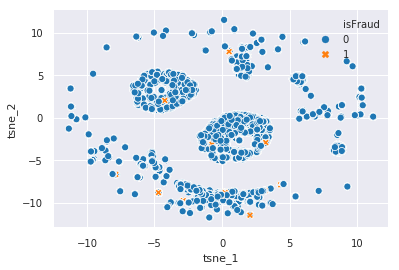

In [87]:
sns.scatterplot(x="tsne_1", y="tsne_2", hue='isFraud', style='isFraud', data=tsne_df, palette='Set2')


In [57]:
import math
epilson = 0.001
delta = 0.33
(math.log(10)+ math.log(2/delta)) / (2*epilson**2)

2052197.4490378012

In [ ]:
def plot_t_sne(df, features, n_components, perplexities, seed, init='random'):
    (fig, ax) = plt.subplots(1, len(perplexities), figsize=(15, 8))
    for i, perplexity in enumerate(perplexities):
        ax_ = ax[i]
        t0 = time()
        X_tsne = TSNE(n_components=n_components, init=init, random_state=seed, perplexity=perplexity)
        Y = X_tsne.fit_transform(df[features])
        t1 = time()
        print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
        ax_.set_title("Perplexity=%d" % perplexity)
        ax_.scatter(Y[red, 0], Y[red, 1], c="r")
        ax_.scatter(Y[green, 0], Y[green, 1], c="g")
        #ax_.xaxis.set_major_formatter(NullFormatter())
        #ax_.yaxis.set_major_formatter(NullFormatter())
        ax_.axis('tight')

In [ ]:
cs_res_df = pd.DataFrame(columns=['col_name', 'auc'])
for idx, c in enumerate(V_cols):
    cs_res_df.loc[idx, 'col_name'] = c
    cs_res_df.loc[idx, 'auc'] = covariate_shift(train_data=train_transaction_data, 
                                                test_data=test_transaction_data, 
                                                feature=c, 
                                                seed=42)
cs_res_df    

* ***Other columns***

In [52]:
train_transaction_data[other_cols].head()

addr1  addr2  dist1  dist2 P_emaildomain R_emaildomain
0  315.0   87.0   19.0    NaN           NaN           NaN
1  325.0   87.0    NaN    NaN     gmail.com           NaN
2  330.0   87.0  287.0    NaN   outlook.com           NaN
3  476.0   87.0    NaN    NaN     yahoo.com           NaN
4  420.0   87.0    NaN    NaN     gmail.com           NaN

* ***categories columns***


In [10]:
categories_cols = []
for k, v in train_transaction_data.dtypes.items():
    if v == 'object':
        categories_cols.append(k)

In [11]:
statistic.resumetable(train_transaction_data[categories_cols])

Dataset Shape: (590540, 14)


Name  dtypes  Missing  Uniques First Value Second Value  \
0       ProductCD  object        0        5           W            W   
1           card4  object     1577        4    discover   mastercard   
2           card6  object     1571        4      credit       credit   
3   P_emaildomain  object    94456       59         NaN    gmail.com   
4   R_emaildomain  object   453249       60         NaN          NaN   
5              M1  object   271100        2           T          NaN   
6              M2  object   271100        2           T          NaN   
7              M3  object   271100        2           T          NaN   
8              M4  object   281444        3          M2           M0   
9              M5  object   350482        2           F            T   
10             M6  object   169360        2           T            T   
11             M7  object   346265        2         NaN          NaN   
12             M8  object   346252        2         NaN          NaN   
13             M9  object   346252        2         NaN          NaN   

    Third Value  Entropy  
0             W     1.28  
1          visa     1.09  
2         debit     0.82  
3   outlook.com     2.68  
4           NaN     2.76  
5             T     0.00  
6             T     0.49  
7             T     0.75  
8            M0     1.31  
9             F     0.99  
10            F     1.00  
11            F     0.57  
12            F     0.95  
13            F     0.63

In [12]:
fraud_data = train_data[train_data.isFraud == 1]
not_fraud_data = train_data[train_data.isFraud != 1]

### Feature interaction

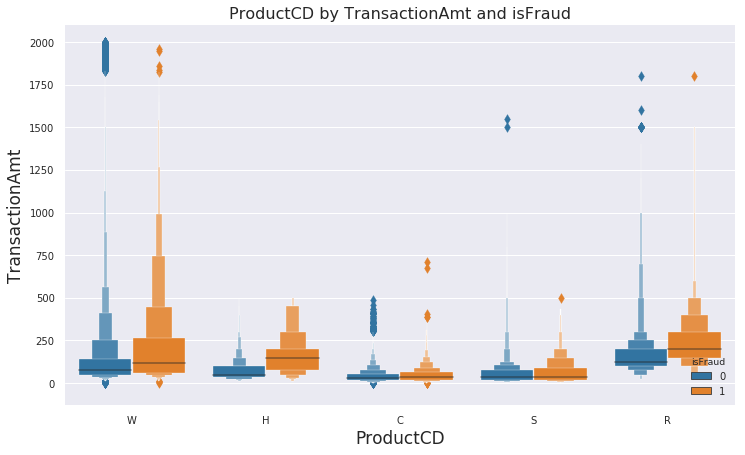

In [84]:
plot_interaction_w_target(train_transaction_data[train_transaction_data['TransactionAmt'] <= 2000], 
                          'ProductCD', 'TransactionAmt', 'isFraud')


In [10]:
train_identity_data.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [ ]:
print('Unique transcation id at identity table:{}'.format(train_identity_data.TransactionID.nunique()))
print('Unique transcation id at identity table:{}'.format(train_transaction_data.TransactionID.nunique()))

In [10]:
params = {'objective': 'binary', 
          'boosting_type': 'gbdt', 
          'subsample': 1, 
          'bagging_seed': 11, 
          'metric': ['auc'], 
          'random_state': 42}
    
def covariate_shift(train_data, test_data, feature, params, seed=42):
    df_train = pd.DataFrame(data={feature: train_data[feature], 'is_test': 0})
    df_test = pd.DataFrame(data={feature: test_data[feature], 'is_test': 1})

    # Creating a single dataframe
    df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Encoding if feature is categorical
    if str(df[feature].dtype) in ['object', 'category']:
        df[feature] = LabelEncoder().fit_transform(df[feature].astype(str))
    
    # Splitting it to a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(df[feature], df['is_test'], 
                                                        test_size=0.33, random_state=seed, stratify=df['is_test'])
    clf = lgb.LGBMClassifier(**params, num_boost_round=500)
    clf.fit(X_train.values.reshape(-1, 1), y_train)
    roc_auc =  roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

    del df, X_train, y_train, X_test, y_test
    gc.collect()
    
    return roc_auc

In [12]:
covariate_shift(train_transaction_data, test_transaction_data, 'TransactionAmt', params)

0.5372948302458558